In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
)
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import pickle
import shap
import os
from datetime import datetime
import sys
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

# plt.rcParams['font.family'] ='Malgun Gothic' # ÏúàÎèÑÏö∞
plt.rcParams['font.family'] ='AppleGothic' # Îß•
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

class SewagePredictionPipeline:
    def __init__(self, data_path_template='../data/add_feature/{}_add_feature.csv'):
        """
        ÌïòÏàòÏ≤òÎ¶¨Îüâ ÏòàÏ∏° Î™®Îç∏ÎßÅ ÌååÏù¥ÌîÑÎùºÏù∏
        
        Parameters:
        -----------
        data_path_template : str
            Îç∞Ïù¥ÌÑ∞ ÌååÏùº Í≤ΩÎ°ú ÌÖúÌîåÎ¶ø (ÏÑºÌÑ∞Î™ÖÏù¥ Îì§Ïñ¥Í∞à Î∂ÄÎ∂ÑÏùÄ {}Î°ú ÌëúÏãú)
        """
        self.data_path_template = data_path_template
        self.centers = ['nanji', 'jungnang', 'seonam', 'tancheon']  # Ïã§Ï†ú ÏÑºÌÑ∞Î™ÖÏúºÎ°ú ÏàòÏ†ï ÌïÑÏöî
        
        # Ï†úÏô∏Ìï† Ïª¨Îüº Ï†ïÏùò
        self.not_use_col = [
            'ÎÇ†Ïßú',
            '1Ï≤òÎ¶¨Ïû•','2Ï≤òÎ¶¨Ïû•','Ï†ïÌôîÏ°∞','Ï§ëÍ≥ÑÌéåÌîÑÏû•','Ìï©Í≥Ñ','ÏãúÏÑ§ÌòÑÎåÄÌôî',
            '3Ï≤òÎ¶¨Ïû•','4Ï≤òÎ¶¨Ïû•','Ìï©Í≥Ñ', 'Ìï©Í≥Ñ_1ÏùºÌõÑ','Ìï©Í≥Ñ_2ÏùºÌõÑ',
            'Îì±Í∏â','Îì±Í∏â_1ÏùºÌõÑ','Îì±Í∏â_2ÏùºÌõÑ'
        ]
        
        # ÌöåÍ∑Ä Î™®Îç∏ Ï†ïÏùò
        self.regression_models = {
            'LinearRegression': LinearRegression(),
            'RandomForest': RandomForestRegressor(random_state=42, n_estimators=100),
            'XGBoost': xgb.XGBRegressor(random_state=42, eval_metric='rmse'),
            'CatBoost': cb.CatBoostRegressor(random_state=42, verbose=False),
            'GradientBoost': GradientBoostingRegressor(random_state=42),
            'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1)
        }
        
        # Î∂ÑÎ•ò Î™®Îç∏ Ï†ïÏùò
        self.classification_models = {
            'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
            'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100),
            'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
            'CatBoost': cb.CatBoostClassifier(random_state=42, verbose=False),
            'GradientBoost': GradientBoostingClassifier(random_state=42),
            'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1)
        }
        
        # Í≤∞Í≥º Ï†ÄÏû•Ïö©
        self.results = []
        self.best_models = {}
        
    def load_data(self, center):
        """ÏÑºÌÑ∞Î≥Ñ Îç∞Ïù¥ÌÑ∞ Î°úÎìú"""
        file_path = self.data_path_template.format(center)
        try:
            data = pd.read_csv(file_path)
            print(f"{center} ÏÑºÌÑ∞ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: {data.shape}")
            return data
        except FileNotFoundError:
            print(f"ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§: {file_path}")
            return None
    
    def prepare_features(self, data):
        """ÌîºÏ≤ò Î∞è ÌÉÄÍ≤ü Ï§ÄÎπÑ"""
        # ÏÇ¨Ïö©Ìï† Ïª¨Îüº ÏÑ†Î≥Ñ
        available_cols = [col for col in data.columns if col not in self.not_use_col]
        X = data[available_cols]
        
        # ÌÉÄÍ≤ü Î≥ÄÏàò
        y_reg = data['Ìï©Í≥Ñ_1ÏùºÌõÑ']  # ÌöåÍ∑ÄÏö©
        y_clf = data['Îì±Í∏â_1ÏùºÌõÑ']  # Î∂ÑÎ•òÏö©
        
        return X, y_reg, y_clf
    
    def split_data_temporal(self, X, y, test_size=0.2):
        """ÏãúÍ≥ÑÏó¥ Ï†ïÎ≥¥Î•º Ïú†ÏßÄÌïú Î∂ÑÌï†"""
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        return X_train, X_test, y_train, y_test
    
    def split_data_random(self, X, y, test_size=0.2, stratify=None):
        """ÎûúÎç§ Î∂ÑÌï† (Î∂ÑÎ•òÏãú stratified)"""
        return train_test_split(X, y, test_size=test_size, 
                              stratify=stratify, random_state=42)
    
    def evaluate_regression(self, y_true, y_pred):
        """ÌöåÍ∑Ä Î™®Îç∏ ÌèâÍ∞Ä ÏßÄÌëú Í≥ÑÏÇ∞"""
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        
        # MAPE Í≥ÑÏÇ∞ (0ÏúºÎ°ú ÎÇòÎàÑÍ∏∞ Î∞©ÏßÄ)
        mask = y_true != 0
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.sum() > 0 else np.inf
        
        r2 = r2_score(y_true, y_pred)
        
        return {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R2': r2
        }
    
    def evaluate_classification(self, y_true, y_pred, y_pred_proba=None):
        """Î∂ÑÎ•ò Î™®Îç∏ ÌèâÍ∞Ä ÏßÄÌëú Í≥ÑÏÇ∞"""
        accuracy = accuracy_score(y_true, y_pred)
        precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
        
        metrics = {
            'Accuracy': accuracy,
            'Precision_weighted': precision_weighted,
            'Precision_macro': precision_macro,
            'Recall_weighted': recall_weighted,
            'Recall_macro': recall_macro,
            'F1_weighted': f1_weighted,
            'F1_macro': f1_macro
        }
        
        # ROC AUC (Îã§Ï§ëÎ∂ÑÎ•òÏùò Í≤ΩÏö∞ ovr Î∞©Ïãù ÏÇ¨Ïö©)
        if y_pred_proba is not None:
            try:
                if len(np.unique(y_true)) == 2:
                    auc_score = roc_auc_score(y_true, y_pred_proba[:, 1])
                else:
                    auc_score = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
                metrics['AUC'] = auc_score
            except:
                metrics['AUC'] = 0
        
        return metrics
    
    def train_and_evaluate_models(self, center):
        """ÏÑºÌÑ∞Î≥Ñ Î™®Îì† Î™®Îç∏ ÌïôÏäµ Î∞è ÌèâÍ∞Ä"""
        print(f"\n{'='*50}")
        print(f"{center.upper()} ÏÑºÌÑ∞ Î™®Îç∏ ÌïôÏäµ ÏãúÏûë")
        print(f"{'='*50}")
        
        # Îç∞Ïù¥ÌÑ∞ Î°úÎìú
        data = self.load_data(center)
        if data is None:
            return
        
        # ÌîºÏ≤ò Ï§ÄÎπÑ
        X, y_reg, y_clf = self.prepare_features(data)
        
        print(f"ÌîºÏ≤ò Ïàò: {X.shape[1]}")
        print(f"Îç∞Ïù¥ÌÑ∞ Ïàò: {X.shape[0]}")
        print(f"Î∂ÑÎ•ò ÌÉÄÍ≤ü ÌÅ¥ÎûòÏä§: {sorted(y_clf.unique())}")
        
        # Îëê Í∞ÄÏßÄ Î∂ÑÌï† Î∞©Î≤ïÏúºÎ°ú Î™®Îç∏ ÌïôÏäµ
        split_methods = ['temporal', 'random']
        
        for split_method in split_methods:
            print(f"\n--- {split_method.upper()} Î∂ÑÌï† Î∞©Î≤ï ---")
            
            # Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
            if split_method == 'temporal':
                X_train_reg, X_test_reg, y_train_reg, y_test_reg = self.split_data_temporal(X, y_reg)
                X_train_clf, X_test_clf, y_train_clf, y_test_clf = self.split_data_temporal(X, y_clf)
            else:
                X_train_reg, X_test_reg, y_train_reg, y_test_reg = self.split_data_random(X, y_reg)
                X_train_clf, X_test_clf, y_train_clf, y_test_clf = self.split_data_random(X, y_clf, stratify=y_clf)
            
            # ÌöåÍ∑Ä Î™®Îç∏ ÌïôÏäµ
            print(f"\nÌöåÍ∑Ä Î™®Îç∏ ÌïôÏäµ ({split_method}):")
            for model_name, model in self.regression_models.items():
                try:
                    model.fit(X_train_reg, y_train_reg)
                    y_pred = model.predict(X_test_reg)
                    metrics = self.evaluate_regression(y_test_reg, y_pred)
                    
                    result = {
                        'center': center,
                        'split_method': split_method,
                        'task': 'regression',
                        'model': model_name,
                        **metrics
                    }
                    self.results.append(result)
                    
                    print(f"{model_name}: R2={metrics['R2']:.4f}, RMSE={metrics['RMSE']:.2f}")
                    
                except Exception as e:
                    print(f"{model_name} ÌöåÍ∑Ä Î™®Îç∏ ÌïôÏäµ Ïã§Ìå®: {str(e)}")
            
            # Î∂ÑÎ•ò Î™®Îç∏ ÌïôÏäµ
            print(f"\nÎ∂ÑÎ•ò Î™®Îç∏ ÌïôÏäµ ({split_method}):")
            for model_name, model in self.classification_models.items():
                try:
                    model.fit(X_train_clf, y_train_clf)
                    y_pred = model.predict(X_test_clf)
                    
                    # ÌôïÎ•† ÏòàÏ∏° (Í∞ÄÎä•Ìïú Í≤ΩÏö∞)
                    y_pred_proba = None
                    if hasattr(model, 'predict_proba'):
                        y_pred_proba = model.predict_proba(X_test_clf)
                    
                    metrics = self.evaluate_classification(y_test_clf, y_pred, y_pred_proba)
                    
                    result = {
                        'center': center,
                        'split_method': split_method,
                        'task': 'classification',
                        'model': model_name,
                        **metrics
                    }
                    self.results.append(result)
                    
                    print(f"{model_name}: Accuracy={metrics['Accuracy']:.4f}, F1_weighted={metrics['F1_weighted']:.4f}")
                    
                except Exception as e:
                    print(f"{model_name} Î∂ÑÎ•ò Î™®Îç∏ ÌïôÏäµ Ïã§Ìå®: {str(e)}")
    
    def run_all_models(self):
        """Î™®Îì† ÏÑºÌÑ∞Ïóê ÎåÄÌï¥ Î™®Îç∏ ÌïôÏäµ Ïã§Ìñâ"""
        print("Ï†ÑÏ≤¥ Î™®Îç∏ ÌïôÏäµ ÌååÏù¥ÌîÑÎùºÏù∏ ÏãúÏûë")
        print(f"ÎåÄÏÉÅ ÏÑºÌÑ∞: {self.centers}")
        
        for center in self.centers:
            self.train_and_evaluate_models(center)
        
        # Í≤∞Í≥ºÎ•º DataFrameÏúºÎ°ú Î≥ÄÌôò
        self.results_df = pd.DataFrame(self.results)
        
        # Í≤∞Í≥º Ï†ÄÏû•
        self.results_df.to_csv('../results/all_model_results.csv', index=False, encoding='utf-8-sig')
        print(f"\nÏ†ÑÏ≤¥ Í≤∞Í≥ºÍ∞Ä '../results/all_model_results.csv'Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")
        
        return self.results_df
    
    def find_best_models(self):
        """ÏÑºÌÑ∞Î≥Ñ, ÌÉúÏä§ÌÅ¨Î≥Ñ ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏ Ï∞æÍ∏∞"""
        if not hasattr(self, 'results_df'):
            print("Î®ºÏ†Ä run_all_models()Î•º Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.")
            return
        
        best_models_list = []
        
        for center in self.centers:
            for task in ['regression', 'classification']:
                center_task_data = self.results_df[
                    (self.results_df['center'] == center) & 
                    (self.results_df['task'] == task)
                ]
                
                if len(center_task_data) == 0:
                    continue
                
                if task == 'regression':
                    # R2Í∞Ä ÎÜíÏùÄ Î™®Îç∏ ÏÑ†ÌÉù
                    best_model = center_task_data.loc[center_task_data['R2'].idxmax()]
                else:
                    # F1_weightedÍ∞Ä ÎÜíÏùÄ Î™®Îç∏ ÏÑ†ÌÉù
                    best_model = center_task_data.loc[center_task_data['F1_weighted'].idxmax()]
                
                best_models_list.append(best_model.to_dict())
        
        self.best_models_df = pd.DataFrame(best_models_list)
        self.best_models_df.to_csv('../results/best_models.csv', index=False, encoding='utf-8-sig')
        
        print("Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï†ïÎ≥¥:")
        print(self.best_models_df[['center', 'task', 'model', 'split_method']])
        
        return self.best_models_df
    
    def visualize_results(self):
        """Í≤∞Í≥º ÏãúÍ∞ÅÌôî"""
        if not hasattr(self, 'results_df'):
            print("Î®ºÏ†Ä run_all_models()Î•º Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.")
            return
        
        # Í≤∞Í≥º ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
        import os
        os.makedirs('../results/visualizations', exist_ok=True)
        
        # 1. Î∂ÑÌï† Î∞©Î≤ïÏóê Îî∞Î•∏ ÏÑºÌÑ∞Î≥Ñ ÏÑ±Îä• ÎπÑÍµê
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # ÌöåÍ∑Ä - R2 ÎπÑÍµê
        reg_data = self.results_df[self.results_df['task'] == 'regression']
        reg_pivot = reg_data.pivot_table(
            values='R2', index=['center', 'model'], 
            columns='split_method', aggfunc='mean'
        ).reset_index()
        
        ax1 = axes[0, 0]
        reg_pivot_plot = reg_pivot.groupby('center')[['temporal', 'random']].mean()
        reg_pivot_plot.plot(kind='bar', ax=ax1, title='ÏÑºÌÑ∞Î≥Ñ ÌöåÍ∑Ä R2 ÏÑ±Îä• ÎπÑÍµê (Î∂ÑÌï†Î∞©Î≤ïÎ≥Ñ)')
        ax1.set_ylabel('R2 Score')
        ax1.legend(['Temporal Split', 'Random Split'])
        
        # Î∂ÑÎ•ò - F1 ÎπÑÍµê
        clf_data = self.results_df[self.results_df['task'] == 'classification']
        clf_pivot = clf_data.pivot_table(
            values='F1_weighted', index=['center', 'model'], 
            columns='split_method', aggfunc='mean'
        ).reset_index()
        
        ax2 = axes[0, 1]
        clf_pivot_plot = clf_pivot.groupby('center')[['temporal', 'random']].mean()
        clf_pivot_plot.plot(kind='bar', ax=ax2, title='ÏÑºÌÑ∞Î≥Ñ Î∂ÑÎ•ò F1 ÏÑ±Îä• ÎπÑÍµê (Î∂ÑÌï†Î∞©Î≤ïÎ≥Ñ)')
        ax2.set_ylabel('F1 Score (Weighted)')
        ax2.legend(['Temporal Split', 'Random Split'])
        
        # ÏÑºÌÑ∞Î≥Ñ Î™®Îç∏ ÏÑ±Îä• ÏÉÅÏÑ∏ ÎπÑÍµê
        ax3 = axes[1, 0]
        reg_model_perf = reg_data.groupby(['center', 'model'])['R2'].mean().unstack()
        reg_model_perf.plot(kind='bar', ax=ax3, title='ÏÑºÌÑ∞Î≥Ñ ÌöåÍ∑Ä Î™®Îç∏ R2 ÏÑ±Îä• ÎπÑÍµê')
        ax3.set_ylabel('R2 Score')
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        ax4 = axes[1, 1]
        clf_model_perf = clf_data.groupby(['center', 'model'])['F1_weighted'].mean().unstack()
        clf_model_perf.plot(kind='bar', ax=ax4, title='ÏÑºÌÑ∞Î≥Ñ Î∂ÑÎ•ò Î™®Îç∏ F1 ÏÑ±Îä• ÎπÑÍµê')
        ax4.set_ylabel('F1 Score (Weighted)')
        ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.savefig('../results/visualizations/model_performance_comparison.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        print("ÏãúÍ∞ÅÌôî Í≤∞Í≥ºÍ∞Ä '../results/visualizations/' Ìè¥ÎçîÏóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")

# Ïã§Ìñâ ÏòàÏãú
if __name__ == "__main__":
    # ÌååÏù¥ÌîÑÎùºÏù∏ Ï¥àÍ∏∞Ìôî
    pipeline = SewagePredictionPipeline()
    
    # Ïã§Ï†ú ÏÑºÌÑ∞Î™ÖÏúºÎ°ú ÏàòÏ†ï (Ïòà: ['nanji', 'jungnang', 'seonam', 'tancheon'])
    # pipeline.centers = ['your_actual_center_names']
    
    # Î™®Îì† Î™®Îç∏ ÌïôÏäµ Î∞è ÌèâÍ∞Ä
    results = pipeline.run_all_models()
    
    # Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï∞æÍ∏∞
    best_models = pipeline.find_best_models()
    
    # Í≤∞Í≥º ÏãúÍ∞ÅÌôî
    pipeline.visualize_results()
    
    print("\nÌååÏù¥ÌîÑÎùºÏù∏ Ïã§Ìñâ ÏôÑÎ£å!")
    print("Îã§Ïùå Îã®Í≥Ñ: Î≤†Ïä§Ìä∏ Î™®Îç∏Îì§Ïóê ÎåÄÌïú Ìï¥ÏÑù Í∞ÄÎä•ÏÑ± Î∂ÑÏÑù (SHAP, LIME Îì±)")

Ï†ÑÏ≤¥ Î™®Îç∏ ÌïôÏäµ ÌååÏù¥ÌîÑÎùºÏù∏ ÏãúÏûë
ÎåÄÏÉÅ ÏÑºÌÑ∞: ['nanji', 'jungnang', 'seonam', 'tancheon']

NANJI ÏÑºÌÑ∞ Î™®Îç∏ ÌïôÏäµ ÏãúÏûë
nanji ÏÑºÌÑ∞ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: (3069, 44)
ÌîºÏ≤ò Ïàò: 33
Îç∞Ïù¥ÌÑ∞ Ïàò: 3069
Î∂ÑÎ•ò ÌÉÄÍ≤ü ÌÅ¥ÎûòÏä§: [0, 1, 2, 3]

--- TEMPORAL Î∂ÑÌï† Î∞©Î≤ï ---

ÌöåÍ∑Ä Î™®Îç∏ ÌïôÏäµ (temporal):
LinearRegression: R2=0.5030, RMSE=80043.77
RandomForest: R2=0.5373, RMSE=77233.02
XGBoost: R2=0.3688, RMSE=90207.46
CatBoost: R2=0.5197, RMSE=78689.43
GradientBoost: R2=0.4706, RMSE=82610.40
LightGBM: R2=0.5246, RMSE=78283.70

Î∂ÑÎ•ò Î™®Îç∏ ÌïôÏäµ (temporal):
LogisticRegression: Accuracy=0.6743, F1_weighted=0.5931
RandomForest: Accuracy=0.7476, F1_weighted=0.7203
XGBoost: Accuracy=0.7036, F1_weighted=0.7087
CatBoost: Accuracy=0.7182, F1_weighted=0.7167
GradientBoost: Accuracy=0.7068, F1_weighted=0.6918
LightGBM: Accuracy=0.6922, F1_weighted=0.6968

--- RANDOM Î∂ÑÌï† Î∞©Î≤ï ---

ÌöåÍ∑Ä Î™®Îç∏ ÌïôÏäµ (random):
LinearRegression: R2=0.5870, RMSE=85958.95
RandomForest: R

OSError: Cannot save file into a non-existent directory: '../results'

In [ ]:
class ModelInterpretationPipeline:
    def __init__(self, best_models_path='../results/best_models.csv', 
                 data_path_template='../data/add_feature/{}_add_feature.csv'):
        """
        Î™®Îç∏ Ìï¥ÏÑù Í∞ÄÎä•ÏÑ± Î∂ÑÏÑù ÌååÏù¥ÌîÑÎùºÏù∏
        
        Parameters:
        -----------
        best_models_path : str
            Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï†ïÎ≥¥ CSV ÌååÏùº Í≤ΩÎ°ú
        data_path_template : str
            Îç∞Ïù¥ÌÑ∞ ÌååÏùº Í≤ΩÎ°ú ÌÖúÌîåÎ¶ø
        """
        self.best_models_path = best_models_path
        self.data_path_template = data_path_template
        
        # Ï†úÏô∏Ìï† Ïª¨Îüº Ï†ïÏùò (Î©îÏù∏ ÌååÏù¥ÌîÑÎùºÏù∏Í≥º ÎèôÏùº)
        self.not_use_col = [
            'ÎÇ†Ïßú',
            '1Ï≤òÎ¶¨Ïû•','2Ï≤òÎ¶¨Ïû•','Ï†ïÌôîÏ°∞','Ï§ëÍ≥ÑÌéåÌîÑÏû•','Ìï©Í≥Ñ','ÏãúÏÑ§ÌòÑÎåÄÌôî',
            '3Ï≤òÎ¶¨Ïû•','4Ï≤òÎ¶¨Ïû•','Ìï©Í≥Ñ', 'Ìï©Í≥Ñ_1ÏùºÌõÑ','Ìï©Í≥Ñ_2ÏùºÌõÑ',
            'Îì±Í∏â','Îì±Í∏â_1ÏùºÌõÑ','Îì±Í∏â_2ÏùºÌõÑ'
        ]
        
        # Í≤∞Í≥º Ï†ÄÏû• ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
        os.makedirs('../models/best_models', exist_ok=True)
        os.makedirs('../results/interpretations', exist_ok=True)
        
    def load_best_models_info(self):
        """Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï†ïÎ≥¥ Î°úÎìú"""
        self.best_models_df = pd.read_csv(self.best_models_path)
        print(f"Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï†ïÎ≥¥ Î°úÎìú ÏôÑÎ£å: {len(self.best_models_df)}Í∞ú Î™®Îç∏")
        return self.best_models_df
    
    def load_and_prepare_data(self, center):
        """ÏÑºÌÑ∞Î≥Ñ Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨"""
        file_path = self.data_path_template.format(center)
        data = pd.read_csv(file_path)
        
        # ÌîºÏ≤ò Î∞è ÌÉÄÍ≤ü Ï§ÄÎπÑ
        available_cols = [col for col in data.columns if col not in self.not_use_col]
        X = data[available_cols]
        y_reg = data['Ìï©Í≥Ñ_1ÏùºÌõÑ']
        y_clf = data['Îì±Í∏â_1ÏùºÌõÑ']
        
        return X, y_reg, y_clf, data
    
    def get_model_instance(self, model_name):
        """Î™®Îç∏ Ïù¥Î¶ÑÏóê Îî∞Î•∏ Ïù∏Ïä§ÌÑ¥Ïä§ Î∞òÌôò"""
        from sklearn.linear_model import LinearRegression, LogisticRegression
        from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
        import xgboost as xgb
        import catboost as cb
        import lightgbm as lgb
        
        model_dict = {
            'LinearRegression': LinearRegression(),
            'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
            'RandomForest': {
                'regression': RandomForestRegressor(random_state=42, n_estimators=100),
                'classification': RandomForestClassifier(random_state=42, n_estimators=100)
            },
            'XGBoost': {
                'regression': xgb.XGBRegressor(random_state=42, eval_metric='rmse'),
                'classification': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
            },
            'CatBoost': {
                'regression': cb.CatBoostRegressor(random_state=42, verbose=False),
                'classification': cb.CatBoostClassifier(random_state=42, verbose=False)
            },
            'GradientBoost': {
                'regression': GradientBoostingRegressor(random_state=42),
                'classification': GradientBoostingClassifier(random_state=42)
            },
            'LightGBM': {
                'regression': lgb.LGBMRegressor(random_state=42, verbose=-1),
                'classification': lgb.LGBMClassifier(random_state=42, verbose=-1)
            }
        }
        
        return model_dict[model_name]
    
    def split_data(self, X, y, split_method, test_size=0.2, stratify=None):
        """Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†"""
        if split_method == 'temporal':
            split_idx = int(len(X) * (1 - test_size))
            X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
            y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        else:  # random
            from sklearn.model_selection import train_test_split
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, stratify=stratify, random_state=42
            )
        
        return X_train, X_test, y_train, y_test
    
    def train_and_save_best_model(self, model_info):
        """Î≤†Ïä§Ìä∏ Î™®Îç∏ ÌïôÏäµ Î∞è Ï†ÄÏû•"""
        center = model_info['center']
        task = model_info['task']
        model_name = model_info['model']
        split_method = model_info['split_method']
        
        print(f"\n{center} - {task} - {model_name} Î™®Îç∏ ÌïôÏäµ Ï§ë...")
        
        # Îç∞Ïù¥ÌÑ∞ Î°úÎìú
        X, y_reg, y_clf, raw_data = self.load_and_prepare_data(center)
        
        # ÌÉÄÍ≤ü ÏÑ†ÌÉù
        y = y_reg if task == 'regression' else y_clf
        
        # Î™®Îç∏ Ïù∏Ïä§ÌÑ¥Ïä§ Í∞ÄÏ†∏Ïò§Í∏∞
        model_instance = self.get_model_instance(model_name)
        if isinstance(model_instance, dict):
            model = model_instance[task]
        else:
            model = model_instance
        
        # Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
        stratify = y if task == 'classification' and split_method == 'random' else None
        X_train, X_test, y_train, y_test = self.split_data(X, y, split_method, stratify=stratify)
        
        # Î™®Îç∏ ÌïôÏäµ
        model.fit(X_train, y_train)
        
        # Î™®Îç∏ Ï†ÄÏû•
        model_filename = f"{center}_{task}_{model_name}_{split_method}.pkl"
        model_path = os.path.join('../models/best_models', model_filename)
        
        with open(model_path, 'wb') as f:
            pickle.dump({
                'model': model,
                'feature_names': X.columns.tolist(),
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }, f)
        
        print(f"Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å: {model_path}")
        
        return model, X_train, X_test, y_train, y_test, X.columns.tolist()
    
    def analyze_feature_importance(self, model, X_train, feature_names, center, task, model_name):
        """ÌîºÏ≤ò Ï§ëÏöîÎèÑ Î∂ÑÏÑù"""
        print(f"\n{center} - {task} - {model_name} ÌîºÏ≤ò Ï§ëÏöîÎèÑ Î∂ÑÏÑù Ï§ë...")
        
        plt.figure(figsize=(12, 8))
        
        if hasattr(model, 'feature_importances_'):
            # Tree-based Î™®Îç∏Ïùò Í∏∞Î≥∏ feature importance
            importance = model.feature_importances_
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importance
            }).sort_values('importance', ascending=True)
            
            # ÏÉÅÏúÑ 20Í∞ú ÌîºÏ≤òÎßå ÌëúÏãú
            top_features = importance_df.tail(20)
            
            plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Feature Importance')
            plt.title(f'{center} - {task} - {model_name}\nFeature Importance')
            plt.tight_layout()
            
        elif hasattr(model, 'coef_'):
            # ÏÑ†Ìòï Î™®Îç∏Ïùò Í≥ÑÏàò
            if task == 'classification' and len(model.coef_.shape) > 1:
                # Îã§Ï§ëÎ∂ÑÎ•òÏùò Í≤ΩÏö∞ ÌèâÍ∑† Ï†àÎåìÍ∞í ÏÇ¨Ïö©
                coef = np.mean(np.abs(model.coef_), axis=0)
            else:
                coef = np.abs(model.coef_).flatten()
            
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': coef
            }).sort_values('importance', ascending=True)
            
            # ÏÉÅÏúÑ 20Í∞ú ÌîºÏ≤òÎßå ÌëúÏãú
            top_features = importance_df.tail(20)
            
            plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('|Coefficient|')
            plt.title(f'{center} - {task} - {model_name}\nFeature Coefficients')
            plt.tight_layout()
        
        # Ï†ÄÏû•
        plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_feature_importance.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        return importance_df if 'importance_df' in locals() else None
    
    def analyze_shap(self, model, X_train, X_test, feature_names, center, task, model_name):
        """SHAP Î∂ÑÏÑù"""
        print(f"\n{center} - {task} - {model_name} SHAP Î∂ÑÏÑù Ï§ë...")
        
        try:
            # SHAP explainer ÏÉùÏÑ±
            if model_name in ['XGBoost', 'LightGBM', 'CatBoost']:
                explainer = shap.Explainer(model)
                shap_values = explainer(X_test.iloc[:100])  # Ï≤òÏùå 100Í∞ú ÏÉòÌîåÎßå ÏÇ¨Ïö© (ÏãúÍ∞Ñ Îã®Ï∂ï)
            elif hasattr(model, 'predict_proba'):
                # Tree-based Î∂ÑÎ•ò Î™®Îç∏
                explainer = shap.Explainer(model, X_train.iloc[:100])
                shap_values = explainer(X_test.iloc[:100])
            else:
                # ÏÑ†Ìòï Î™®Îç∏ Îì±
                explainer = shap.Explainer(model, X_train.iloc[:100])
                shap_values = explainer(X_test.iloc[:100])
            
            # 1. Summary Plot
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values, X_test.iloc[:100], feature_names=feature_names, 
                            show=False, max_display=20)
            plt.title(f'{center} - {task} - {model_name}\nSHAP Summary Plot')
            plt.tight_layout()
            plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_shap_summary.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            # 2. Feature Importance Plot
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X_test.iloc[:100], feature_names=feature_names, 
                            plot_type="bar", show=False, max_display=20)
            plt.title(f'{center} - {task} - {model_name}\nSHAP Feature Importance')
            plt.tight_layout()
            plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_shap_importance.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            # 3. Waterfall Plot (Ï≤´ Î≤àÏß∏ ÏÉòÌîå)
            plt.figure(figsize=(12, 8))
            if hasattr(shap_values, 'values'):
                if len(shap_values.values.shape) == 3:  # Îã§Ï§ëÎ∂ÑÎ•ò
                    shap.waterfall_plot(shap_values[0, :, 0], show=False)
                else:
                    shap.waterfall_plot(shap_values[0], show=False)
            else:
                shap.waterfall_plot(shap_values[0], show=False)
            plt.title(f'{center} - {task} - {model_name}\nSHAP Waterfall Plot (First Sample)')
            plt.tight_layout()
            plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_shap_waterfall.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            print(f"SHAP Î∂ÑÏÑù ÏôÑÎ£å: {center} - {task} - {model_name}")
            return shap_values
            
        except Exception as e:
            print(f"SHAP Î∂ÑÏÑù Ïã§Ìå®: {center} - {task} - {model_name}, Error: {str(e)}")
            return None
    
    def analyze_lime(self, model, X_train, X_test, feature_names, center, task, model_name):
        """LIME Î∂ÑÏÑù"""
        print(f"\n{center} - {task} - {model_name} LIME Î∂ÑÏÑù Ï§ë...")
        
        try:
            import lime
            import lime.lime_tabular
            
            # LIME explainer ÏÉùÏÑ±
            if task == 'regression':
                explainer = lime.lime_tabular.LimeTabularExplainer(
                    X_train.values,
                    feature_names=feature_names,
                    mode='regression',
                    verbose=False
                )
                
                # Ï≤´ Î≤àÏß∏ ÌÖåÏä§Ìä∏ ÏÉòÌîå ÏÑ§Î™Ö
                instance = X_test.iloc[0].values
                explanation = explainer.explain_instance(
                    instance, model.predict, num_features=10
                )
                
            else:  # classification
                explainer = lime.lime_tabular.LimeTabularExplainer(
                    X_train.values,
                    feature_names=feature_names,
                    mode='classification',
                    class_names=[str(c) for c in sorted(model.classes_)],
                    verbose=False
                )
                
                # Ï≤´ Î≤àÏß∏ ÌÖåÏä§Ìä∏ ÏÉòÌîå ÏÑ§Î™Ö
                instance = X_test.iloc[0].values
                explanation = explainer.explain_instance(
                    instance, model.predict_proba, num_features=10
                )
            
            # Í≤∞Í≥º ÏãúÍ∞ÅÌôî
            fig = explanation.as_pyplot_figure()
            fig.suptitle(f'{center} - {task} - {model_name}\nLIME Explanation (First Sample)')
            plt.tight_layout()
            plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_lime.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            print(f"LIME Î∂ÑÏÑù ÏôÑÎ£å: {center} - {task} - {model_name}")
            return explanation
            
        except ImportError:
            print("LIME Ìå®ÌÇ§ÏßÄÍ∞Ä ÏÑ§ÏπòÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§. pip install limeÏùÑ Ïã§ÌñâÌïòÏÑ∏Ïöî.")
            return None
        except Exception as e:
            print(f"LIME Î∂ÑÏÑù Ïã§Ìå®: {center} - {task} - {model_name}, Error: {str(e)}")
            return None
    
    def run_interpretation_analysis(self):
        """Ï†ÑÏ≤¥ Ìï¥ÏÑù Í∞ÄÎä•ÏÑ± Î∂ÑÏÑù Ïã§Ìñâ"""
        print("Î™®Îç∏ Ìï¥ÏÑù Í∞ÄÎä•ÏÑ± Î∂ÑÏÑù ÏãúÏûë")
        
        # Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï†ïÎ≥¥ Î°úÎìú
        best_models_df = self.load_best_models_info()
        
        interpretation_results = []
        
        for idx, model_info in best_models_df.iterrows():
            print(f"\n{'='*60}")
            print(f"Î∂ÑÏÑù ÏßÑÌñâ: {model_info['center']} - {model_info['task']} - {model_info['model']}")
            print(f"{'='*60}")
            
            try:
                # Î™®Îç∏ ÌïôÏäµ Î∞è Ï†ÄÏû•
                model, X_train, X_test, y_train, y_test, feature_names = \
                    self.train_and_save_best_model(model_info)
                
                # Feature Importance Î∂ÑÏÑù
                importance_df = self.analyze_feature_importance(
                    model, X_train, feature_names, 
                    model_info['center'], model_info['task'], model_info['model']
                )
                
                # SHAP Î∂ÑÏÑù
                shap_values = self.analyze_shap(
                    model, X_train, X_test, feature_names,
                    model_info['center'], model_info['task'], model_info['model']
                )
                
                # LIME Î∂ÑÏÑù
                lime_explanation = self.analyze_lime(
                    model, X_train, X_test, feature_names,
                    model_info['center'], model_info['task'], model_info['model']
                )
                
                # Í≤∞Í≥º Í∏∞Î°ù
                interpretation_results.append({
                    'center': model_info['center'],
                    'task': model_info['task'],
                    'model': model_info['model'],
                    'split_method': model_info['split_method'],
                    'feature_importance_analyzed': importance_df is not None,
                    'shap_analyzed': shap_values is not None,
                    'lime_analyzed': lime_explanation is not None,
                    'model_saved': True
                })
                
            except Exception as e:
                print(f"Î∂ÑÏÑù Ïã§Ìå®: {model_info['center']} - {model_info['task']} - {model_info['model']}")
                print(f"Ïò§Î•ò: {str(e)}")
                
                interpretation_results.append({
                    'center': model_info['center'],
                    'task': model_info['task'],
                    'model': model_info['model'],
                    'split_method': model_info['split_method'],
                    'feature_importance_analyzed': False,
                    'shap_analyzed': False,
                    'lime_analyzed': False,
                    'model_saved': False,
                    'error': str(e)
                })
        
        # Í≤∞Í≥º Ï†ÄÏû•
        results_df = pd.DataFrame(interpretation_results)
        results_df.to_csv('../results/interpretation_analysis_results.csv', 
                         index=False, encoding='utf-8-sig')
        
        print(f"\n{'='*60}")
        print("Ìï¥ÏÑù Í∞ÄÎä•ÏÑ± Î∂ÑÏÑù ÏôÑÎ£å!")
        print(f"{'='*60}")
        print("\nÎ∂ÑÏÑù Í≤∞Í≥º ÏöîÏïΩ:")
        print(results_df[['center', 'task', 'model', 'feature_importance_analyzed', 
                         'shap_analyzed', 'lime_analyzed', 'model_saved']])
        
        return results_df
    
    def create_summary_report(self):
        """Ï¢ÖÌï© Î≥¥Í≥†ÏÑú ÏÉùÏÑ±"""
        if not os.path.exists('../results/interpretation_analysis_results.csv'):
            print("Î®ºÏ†Ä run_interpretation_analysis()Î•º Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.")
            return
        
        results_df = pd.read_csv('../results/interpretation_analysis_results.csv')
        
        print("\n" + "="*80)
        print("ÌïòÏàòÏ≤òÎ¶¨Îüâ ÏòàÏ∏° Î™®Îç∏ Ï¢ÖÌï© Î∂ÑÏÑù Î≥¥Í≥†ÏÑú")
        print("="*80)
        
        print("\n1. Î∂ÑÏÑù ÎåÄÏÉÅ Î™®Îç∏ ÌòÑÌô©:")
        print(f"   - Ï¥ù {len(results_df)}Í∞ú Î≤†Ïä§Ìä∏ Î™®Îç∏ Î∂ÑÏÑù")
        print(f"   - ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Ï†ÄÏû•Îêú Î™®Îç∏: {results_df['model_saved'].sum()}Í∞ú")
        
        print("\n2. Ìï¥ÏÑù Í∞ÄÎä•ÏÑ± Î∂ÑÏÑù ÌòÑÌô©:")
        print(f"   - Feature Importance Î∂ÑÏÑù ÏôÑÎ£å: {results_df['feature_importance_analyzed'].sum()}Í∞ú")
        print(f"   - SHAP Î∂ÑÏÑù ÏôÑÎ£å: {results_df['shap_analyzed'].sum()}Í∞ú")
        print(f"   - LIME Î∂ÑÏÑù ÏôÑÎ£å: {results_df['lime_analyzed'].sum()}Í∞ú")
        
        print("\n3. ÏÑºÌÑ∞Î≥Ñ Î∂ÑÏÑù ÌòÑÌô©:")
        center_summary = results_df.groupby('center').agg({
            'model_saved': 'sum',
            'feature_importance_analyzed': 'sum',
            'shap_analyzed': 'sum',
            'lime_analyzed': 'sum'
        }).round(0)
        print(center_summary)
        
        print("\n4. ÌÉúÏä§ÌÅ¨Î≥Ñ Î∂ÑÏÑù ÌòÑÌô©:")
        task_summary = results_df.groupby('task').agg({
            'model_saved': 'sum',
            'feature_importance_analyzed': 'sum',
            'shap_analyzed': 'sum',
            'lime_analyzed': 'sum'
        }).round(0)
        print(task_summary)
        
        print("\n5. Ï†ÄÏû•Îêú ÌååÏùº ÏúÑÏπò:")
        print("   - Î™®Îç∏ ÌååÏùº: '../models/best_models/' Ìè¥Îçî")
        print("   - Ìï¥ÏÑù Í≤∞Í≥º Ïù¥ÎØ∏ÏßÄ: '../results/interpretations/' Ìè¥Îçî")
        print("   - Î∂ÑÏÑù Í≤∞Í≥º CSV: '../results/' Ìè¥Îçî")
        
        print("\n" + "="*80)
        print("Î≥¥Í≥†ÏÑú ÏÉùÏÑ± ÏôÑÎ£å!")
        print("="*80)


# Ïã§Ìñâ ÏòàÏãú
if __name__ == "__main__":
    # Ìï¥ÏÑù Í∞ÄÎä•ÏÑ± Î∂ÑÏÑù ÌååÏù¥ÌîÑÎùºÏù∏ Ï¥àÍ∏∞Ìôî
    interpretation_pipeline = ModelInterpretationPipeline()
    
    # Ï†ÑÏ≤¥ Ìï¥ÏÑù Î∂ÑÏÑù Ïã§Ìñâ
    results = interpretation_pipeline.run_interpretation_analysis()
    
    # Ï¢ÖÌï© Î≥¥Í≥†ÏÑú ÏÉùÏÑ±
    interpretation_pipeline.create_summary_report()
    
    print("\nÎã§Ïùå Îã®Í≥Ñ ÏïàÎÇ¥:")
    print("1. '../models/best_models/' Ìè¥ÎçîÏùò Î™®Îç∏ ÌååÏùºÎì§ÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏°")
    print("2. '../results/interpretations/' Ìè¥ÎçîÏùò ÏãúÍ∞ÅÌôî Í≤∞Í≥º Í≤ÄÌÜ†")
    print("3. ÌïÑÏöîÏãú Ï∂îÍ∞ÄÏ†ÅÏù∏ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù ÏàòÌñâ")

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
ÌïòÏàòÏ≤òÎ¶¨Îüâ ÏòàÏ∏° Î™®Îç∏ÎßÅ ÌîÑÎ°úÏ†ùÌä∏ Î©îÏù∏ Ïã§Ìñâ Ïä§ÌÅ¨Î¶ΩÌä∏
"""


# ÌïÑÏöîÌïú ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
def create_directories():
    """ÌïÑÏöîÌïú ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±"""
    directories = [
        '../results',
        '../results/visualizations', 
        '../results/interpretations',
        '../models',
        '../models/best_models'
    ]
    
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
        print(f"ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±/ÌôïÏù∏: {directory}")

def check_data_files():
    """Îç∞Ïù¥ÌÑ∞ ÌååÏùº Ï°¥Ïû¨ ÌôïÏù∏"""
    centers = ['nanji', 'jungnang', 'seonam', 'tancheon']  # Ïã§Ï†ú ÏÑºÌÑ∞Î™ÖÏúºÎ°ú ÏàòÏ†ï ÌïÑÏöî
    data_path_template = '../data/add_feature/{}_add_feature.csv'
    
    missing_files = []
    existing_files = []
    
    for center in centers:
        file_path = data_path_template.format(center)
        if os.path.exists(file_path):
            existing_files.append(file_path)
            # ÌååÏùº Ï†ïÎ≥¥ Ï∂úÎ†•
            df = pd.read_csv(file_path)
            print(f"‚úì {center} Îç∞Ïù¥ÌÑ∞: {df.shape[0]}Ìñâ x {df.shape[1]}Ïó¥")
        else:
            missing_files.append(file_path)
            print(f"‚úó ÌååÏùº ÏóÜÏùå: {file_path}")
    
    if missing_files:
        print(f"\n‚ö†Ô∏è ÎàÑÎùΩÎêú ÌååÏùºÏù¥ ÏûàÏäµÎãàÎã§:")
        for file in missing_files:
            print(f"  - {file}")
        print("\nÏÑºÌÑ∞Î™ÖÏùÑ Ïã§Ï†ú ÌååÏùºÎ™ÖÏóê ÎßûÍ≤å ÏàòÏ†ïÌï¥Ï£ºÏÑ∏Ïöî.")
        return False, existing_files
    
    print(f"\n‚úÖ Î™®Îì† Îç∞Ïù¥ÌÑ∞ ÌååÏùºÏù¥ ÌôïÏù∏ÎêòÏóàÏäµÎãàÎã§. ({len(existing_files)}Í∞ú)")
    return True, existing_files

def install_requirements():
    """ÌïÑÏöîÌïú Ìå®ÌÇ§ÏßÄ ÏÑ§Ïπò ÌôïÏù∏"""
    required_packages = [
        'pandas', 'numpy', 'matplotlib', 'seaborn', 
        'scikit-learn', 'xgboost', 'catboost', 'lightgbm',
        'shap', 'lime'
    ]
    
    missing_packages = []
    
    for package in required_packages:
        try:
            __import__(package)
        except ImportError:
            missing_packages.append(package)
    
    if missing_packages:
        print(f"‚ö†Ô∏è Îã§Ïùå Ìå®ÌÇ§ÏßÄÎì§ÏùÑ ÏÑ§ÏπòÌï¥Ïïº Ìï©ÎãàÎã§:")
        for package in missing_packages:
            print(f"  - {package}")
        print(f"\nÏÑ§Ïπò Î™ÖÎ†πÏñ¥:")
        print(f"pip install {' '.join(missing_packages)}")
        return False
    
    print("‚úÖ Î™®Îì† ÌïÑÏàò Ìå®ÌÇ§ÏßÄÍ∞Ä ÏÑ§ÏπòÎêòÏñ¥ ÏûàÏäµÎãàÎã§.")
    return True

def main():
    """Î©îÏù∏ Ïã§Ìñâ Ìï®Ïàò"""
    print("="*80)
    print("ÌïòÏàòÏ≤òÎ¶¨Îüâ ÏòàÏ∏° Î™®Îç∏ÎßÅ ÌîÑÎ°úÏ†ùÌä∏ Ïã§Ìñâ")
    print(f"Ïã§Ìñâ ÏãúÍ∞Ñ: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*80)
    
    # 1. ÌôòÍ≤Ω ÏÑ§Ï†ï
    print("\n1. ÌôòÍ≤Ω ÏÑ§Ï†ï Ï§ë...")
    create_directories()
    
    # 2. Ìå®ÌÇ§ÏßÄ ÌôïÏù∏
    print("\n2. ÌïÑÏàò Ìå®ÌÇ§ÏßÄ ÌôïÏù∏ Ï§ë...")
    if not install_requirements():
        print("‚ùå ÌïÑÏàò Ìå®ÌÇ§ÏßÄÎ•º Î®ºÏ†Ä ÏÑ§ÏπòÌï¥Ï£ºÏÑ∏Ïöî.")
        return
    
    # 3. Îç∞Ïù¥ÌÑ∞ ÌååÏùº ÌôïÏù∏
    print("\n3. Îç∞Ïù¥ÌÑ∞ ÌååÏùº ÌôïÏù∏ Ï§ë...")
    data_check, existing_files = check_data_files()
    if not data_check:
        print("‚ùå Îç∞Ïù¥ÌÑ∞ ÌååÏùºÏùÑ ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.")
        # Ïã§Ï†ú Ï°¥Ïû¨ÌïòÎäî ÌååÏùºÎ°ú ÏÑºÌÑ∞Î™Ö Ï∂îÎ°†
        if existing_files:
            print("\nüí° Î∞úÍ≤¨Îêú ÌååÏùºÎì§Î°úÎ∂ÄÌÑ∞ ÏÑºÌÑ∞Î™ÖÏùÑ Ï∂îÎ°†Ìï¥Î≥¥ÏÑ∏Ïöî:")
            for file_path in existing_files:
                filename = os.path.basename(file_path)
                center_name = filename.replace('_add_feature.csv', '')
                print(f"  - ÏÑºÌÑ∞Î™Ö: {center_name}")
        return
    
    # 4. Î©îÏù∏ ÌååÏù¥ÌîÑÎùºÏù∏ Ïã§Ìñâ
    print("\n4. Î™®Îç∏ ÌïôÏäµ ÌååÏù¥ÌîÑÎùºÏù∏ Ïã§Ìñâ Ï§ë...")
    try:
        # Ïó¨Í∏∞ÏÑú Ïã§Ï†ú ÌååÏùºÎ™ÖÏúºÎ°úÎ∂ÄÌÑ∞ ÏÑºÌÑ∞Î™Ö Ï∂îÏ∂ú
        centers = []
        for file_path in existing_files:
            filename = os.path.basename(file_path)
            center_name = filename.replace('_add_feature.csv', '')
            centers.append(center_name)
        
        print(f"Í∞êÏßÄÎêú ÏÑºÌÑ∞: {centers}")
        
        # SewagePredictionPipeline import Î∞è Ïã§Ìñâ
        from main_pipeline import SewagePredictionPipeline  # ÏúÑÏóêÏÑú ÎßåÎì† ÌååÏù¥ÌîÑÎùºÏù∏
        
        # ÌååÏù¥ÌîÑÎùºÏù∏ Ï¥àÍ∏∞Ìôî (Ïã§Ï†ú ÏÑºÌÑ∞Î™ÖÏúºÎ°ú ÏÑ§Ï†ï)
        pipeline = SewagePredictionPipeline()
        pipeline.centers = centers
        
        # Î™®Îì† Î™®Îç∏ ÌïôÏäµ Î∞è ÌèâÍ∞Ä
        print("\nÎ™®Îì† Î™®Îç∏ ÌïôÏäµ Î∞è ÌèâÍ∞Ä ÏãúÏûë...")
        results = pipeline.run_all_models()
        
        # Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï∞æÍ∏∞
        print("\nÎ≤†Ïä§Ìä∏ Î™®Îç∏ Ï∞æÍ∏∞...")
        best_models = pipeline.find_best_models()
        
        # Í≤∞Í≥º ÏãúÍ∞ÅÌôî
        print("\nÍ≤∞Í≥º ÏãúÍ∞ÅÌôî...")
        pipeline.visualize_results()
        
        print("\n‚úÖ 4Îã®Í≥Ñ ÏôÑÎ£å: Î™®Îç∏ ÌïôÏäµ Î∞è ÌèâÍ∞Ä")
        
    except Exception as e:
        print(f"‚ùå Î™®Îç∏ ÌïôÏäµ Ï§ë Ïò§Î•ò Î∞úÏÉù: {str(e)}")
        return
    
    # 5. Ìï¥ÏÑù Í∞ÄÎä•ÏÑ± Î∂ÑÏÑù
    print("\n5. Î™®Îç∏ Ìï¥ÏÑù Í∞ÄÎä•ÏÑ± Î∂ÑÏÑù Ïã§Ìñâ Ï§ë...")
    try:
        from model_interpretation import ModelInterpretationPipeline  # ÏúÑÏóêÏÑú ÎßåÎì† Ìï¥ÏÑù ÌååÏù¥ÌîÑÎùºÏù∏
        
        # Ìï¥ÏÑù ÌååÏù¥ÌîÑÎùºÏù∏ Ï¥àÍ∏∞Ìôî
        interpretation_pipeline = ModelInterpretationPipeline()
        
        # Ï†ÑÏ≤¥ Ìï¥ÏÑù Î∂ÑÏÑù Ïã§Ìñâ
        interpretation_results = interpretation_pipeline.run_interpretation_analysis()
        
        # Ï¢ÖÌï© Î≥¥Í≥†ÏÑú ÏÉùÏÑ±
        interpretation_pipeline.create_summary_report()
        
        print("\n‚úÖ 5Îã®Í≥Ñ ÏôÑÎ£å: Î™®Îç∏ Ìï¥ÏÑù Í∞ÄÎä•ÏÑ± Î∂ÑÏÑù")
        
    except Exception as e:
        print(f"‚ùå Ìï¥ÏÑù Î∂ÑÏÑù Ï§ë Ïò§Î•ò Î∞úÏÉù: {str(e)}")
        print("Î™®Îç∏ ÌïôÏäµÏùÄ ÏôÑÎ£åÎêòÏóàÏúºÎØÄÎ°ú, Ìï¥ÏÑù Î∂ÑÏÑùÏùÄ Î≥ÑÎèÑÎ°ú Ïã§ÌñâÌï† Ïàò ÏûàÏäµÎãàÎã§.")
    
    # 6. ÏµúÏ¢Ö Í≤∞Í≥º ÏöîÏïΩ
    print("\n6. ÏµúÏ¢Ö Í≤∞Í≥º ÏöîÏïΩ")
    print("="*60)
    
    try:
        # Í≤∞Í≥º ÌååÏùºÎì§ ÌôïÏù∏
        result_files = {
            'Ï†ÑÏ≤¥ Î™®Îç∏ Í≤∞Í≥º': '../results/all_model_results.csv',
            'Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï†ïÎ≥¥': '../results/best_models.csv',
            'Ìï¥ÏÑù Î∂ÑÏÑù Í≤∞Í≥º': '../results/interpretation_analysis_results.csv'
        }
        
        for name, path in result_files.items():
            if os.path.exists(path):
                df = pd.read_csv(path)
                print(f"‚úì {name}: {len(df)}Í∞ú Î†àÏΩîÎìú ({path})")
            else:
                print(f"‚úó {name}: ÌååÏùº ÏóÜÏùå ({path})")
        
        print(f"\nüìÅ Í≤∞Í≥º ÌååÏùº ÏúÑÏπò:")
        print(f"  - Î™®Îç∏ ÏÑ±Îä• Í≤∞Í≥º: ../results/")
        print(f"  - ÏãúÍ∞ÅÌôî Í≤∞Í≥º: ../results/visualizations/")
        print(f"  - Ìï¥ÏÑù Î∂ÑÏÑù Í≤∞Í≥º: ../results/interpretations/")
        print(f"  - Ï†ÄÏû•Îêú Î™®Îç∏: ../models/best_models/")
        
        print(f"\nüéâ Ï†ÑÏ≤¥ ÌååÏù¥ÌîÑÎùºÏù∏ Ïã§Ìñâ ÏôÑÎ£å!")
        print(f"ÏôÑÎ£å ÏãúÍ∞Ñ: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        
    except Exception as e:
        print(f"Í≤∞Í≥º ÏöîÏïΩ Ï§ë Ïò§Î•ò: {str(e)}")
    
    print("="*80)

def quick_test():
    """Îπ†Î•∏ ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÏûëÏùÄ Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú)"""
    print("Îπ†Î•∏ ÌÖåÏä§Ìä∏ Î™®Îìú Ïã§Ìñâ...")
    
    # Í∞ÑÎã®Ìïú ÌÖåÏä§Ìä∏ ÏΩîÎìú
    try:
        import pandas as pd
        import numpy as np
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import r2_score
        
        # ÎçîÎØ∏ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
        np.random.seed(42)
        n_samples = 100
        X = pd.DataFrame({
            'feature_1': np.random.normal(0, 1, n_samples),
            'feature_2': np.random.normal(0, 1, n_samples),
            'feature_3': np.random.normal(0, 1, n_samples)
        })
        y = X['feature_1'] * 2 + X['feature_2'] * 1.5 + np.random.normal(0, 0.1, n_samples)
        
        # Í∞ÑÎã®Ìïú Î™®Îç∏ ÌÖåÏä§Ìä∏
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = RandomForestRegressor(n_estimators=10, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        
        print(f"‚úÖ ÌÖåÏä§Ìä∏ ÏôÑÎ£å: R2 = {r2:.4f}")
        print("ÌôòÍ≤ΩÏù¥ Ï†ïÏÉÅÏ†ÅÏúºÎ°ú ÏÑ§Ï†ïÎêòÏóàÏäµÎãàÎã§.")
        
    except Exception as e:
        print(f"‚ùå ÌÖåÏä§Ìä∏ Ïã§Ìå®: {str(e)}")

if __name__ == "__main__":
    # Î™ÖÎ†πÌñâ Ïù∏Ïàò ÌôïÏù∏
    if len(sys.argv) > 1 and sys.argv[1] == "test":
        quick_test()
    else:
        main()

# ipynb ÌòïÌÉúÎ°ú

‚úÖ Ìå®ÌÇ§ÏßÄ import ÏôÑÎ£å
Ïã§Ìñâ ÏãúÍ∞Ñ: 2025-08-28 14:43:36
üîß ÌååÏù¥ÌîÑÎùºÏù∏ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
üìä Îç∞Ïù¥ÌÑ∞ ÌååÏùº ÌôïÏù∏
‚úÖ nanji ÏÑºÌÑ∞ Îç∞Ïù¥ÌÑ∞ Î°úÎìú: (3069, 44)
  üìà ÌîºÏ≤ò Ïàò: 33
  üéØ ÌöåÍ∑Ä ÌÉÄÍ≤ü Î≤îÏúÑ: 442332.8 ~ 1381444.0
  üè∑Ô∏è Î∂ÑÎ•ò ÌÉÄÍ≤ü ÌÅ¥ÎûòÏä§: [0, 1, 2, 3]

‚úÖ jungnang ÏÑºÌÑ∞ Îç∞Ïù¥ÌÑ∞ Î°úÎìú: (3069, 44)
  üìà ÌîºÏ≤ò Ïàò: 33
  üéØ ÌöåÍ∑Ä ÌÉÄÍ≤ü Î≤îÏúÑ: 625472.0 ~ 2745792.0
  üè∑Ô∏è Î∂ÑÎ•ò ÌÉÄÍ≤ü ÌÅ¥ÎûòÏä§: [0, 1, 2, 3]

‚úÖ seonam ÏÑºÌÑ∞ Îç∞Ïù¥ÌÑ∞ Î°úÎìú: (3069, 43)
  üìà ÌîºÏ≤ò Ïàò: 33
  üéØ ÌöåÍ∑Ä ÌÉÄÍ≤ü Î≤îÏúÑ: 1160337.0 ~ 2780034.0
  üè∑Ô∏è Î∂ÑÎ•ò ÌÉÄÍ≤ü ÌÅ¥ÎûòÏä§: [0, 1, 2, 3]

‚úÖ tancheon ÏÑºÌÑ∞ Îç∞Ïù¥ÌÑ∞ Î°úÎìú: (3069, 42)
  üìà ÌîºÏ≤ò Ïàò: 33
  üéØ ÌöåÍ∑Ä ÌÉÄÍ≤ü Î≤îÏúÑ: 543425.0 ~ 1423827.0
  üè∑Ô∏è Î∂ÑÎ•ò ÌÉÄÍ≤ü ÌÅ¥ÎûòÏä§: [0, 1, 2, 3]

‚úÖ 4Í∞ú ÏÑºÌÑ∞ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å
üöÄ Ï†ÑÏ≤¥ Î™®Îç∏ ÌïôÏäµ ÏãúÏûë
ÏòàÏÉÅ Ï¥ù Î™®Îç∏ Ïàò: 4 √ó 2 √ó 2 √ó 6 = 96Í∞ú

üè¢ NANJI ÏÑºÌÑ∞ Ï≤òÎ¶¨ Ï§ë...
‚úÖ nanji ÏÑºÌÑ∞ Îç∞Ïù¥ÌÑ∞ Î°úÎìú: (3069

center split_method        task             model           MAE  \
0  nanji     temporal  regression  LinearRegression  61385.069663   
1  nanji     temporal  regression      RandomForest  50828.108168   
2  nanji     temporal  regression           XGBoost  60785.665462   
3  nanji     temporal  regression          CatBoost  49926.262385   
4  nanji     temporal  regression     GradientBoost  55585.812047   

            MSE          RMSE      MAPE        R2  Accuracy  \
0  6.407005e+09  80043.769543  9.559844  0.503024       NaN   
1  5.964939e+09  77233.016033  7.550802  0.537314       NaN   
2  8.137386e+09  90207.458250  9.140552  0.368803       NaN   
3  6.192026e+09  78689.429033  7.412316  0.519700       NaN   
4  6.824478e+09  82610.401545  8.619728  0.470642       NaN   

   Precision_weighted  Precision_macro  Recall_weighted  Recall_macro  \
0                 NaN              NaN              NaN           NaN   
1                 NaN              NaN              NaN           NaN   
2                 NaN              NaN              NaN           NaN   
3                 NaN              NaN              NaN           NaN   
4                 NaN              NaN              NaN           NaN   

   F1_weighted  F1_macro  AUC  
0          NaN       NaN  NaN  
1          NaN       NaN  NaN  
2          NaN       NaN  NaN  
3          NaN       NaN  NaN  
4          NaN       NaN  NaN

üèÜ Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï∞æÍ∏∞
üèÖ nanji - regression: CatBoost (random) - R2=0.6366
üèÖ nanji - classification: XGBoost (random) - F1_weighted=0.7316
üèÖ jungnang - regression: LightGBM (random) - R2=0.5824
üèÖ jungnang - classification: LightGBM (random) - F1_weighted=0.7102
üèÖ seonam - regression: CatBoost (random) - R2=0.6136
üèÖ seonam - classification: XGBoost (random) - F1_weighted=0.7305
üèÖ tancheon - regression: CatBoost (random) - R2=0.5164
üèÖ tancheon - classification: LightGBM (random) - F1_weighted=0.6598

üíæ Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï†ïÎ≥¥ Ï†ÄÏû•: ../results/best_models.csv

üìã Î≤†Ïä§Ìä∏ Î™®Îç∏ ÏöîÏïΩ (8Í∞ú):


center            task     model split_method        R2 F1_weighted
0     nanji      regression  CatBoost       random   0.63658           -
1     nanji  classification   XGBoost       random         -    0.731569
2  jungnang      regression  LightGBM       random  0.582418           -
3  jungnang  classification  LightGBM       random         -    0.710155
4    seonam      regression  CatBoost       random  0.613639           -
5    seonam  classification   XGBoost       random         -    0.730477
6  tancheon      regression  CatBoost       random  0.516426           -
7  tancheon  classification  LightGBM       random         -    0.659771

üìà ÏÑ±Îä• ÏãúÍ∞ÅÌôî ÏÉùÏÑ±


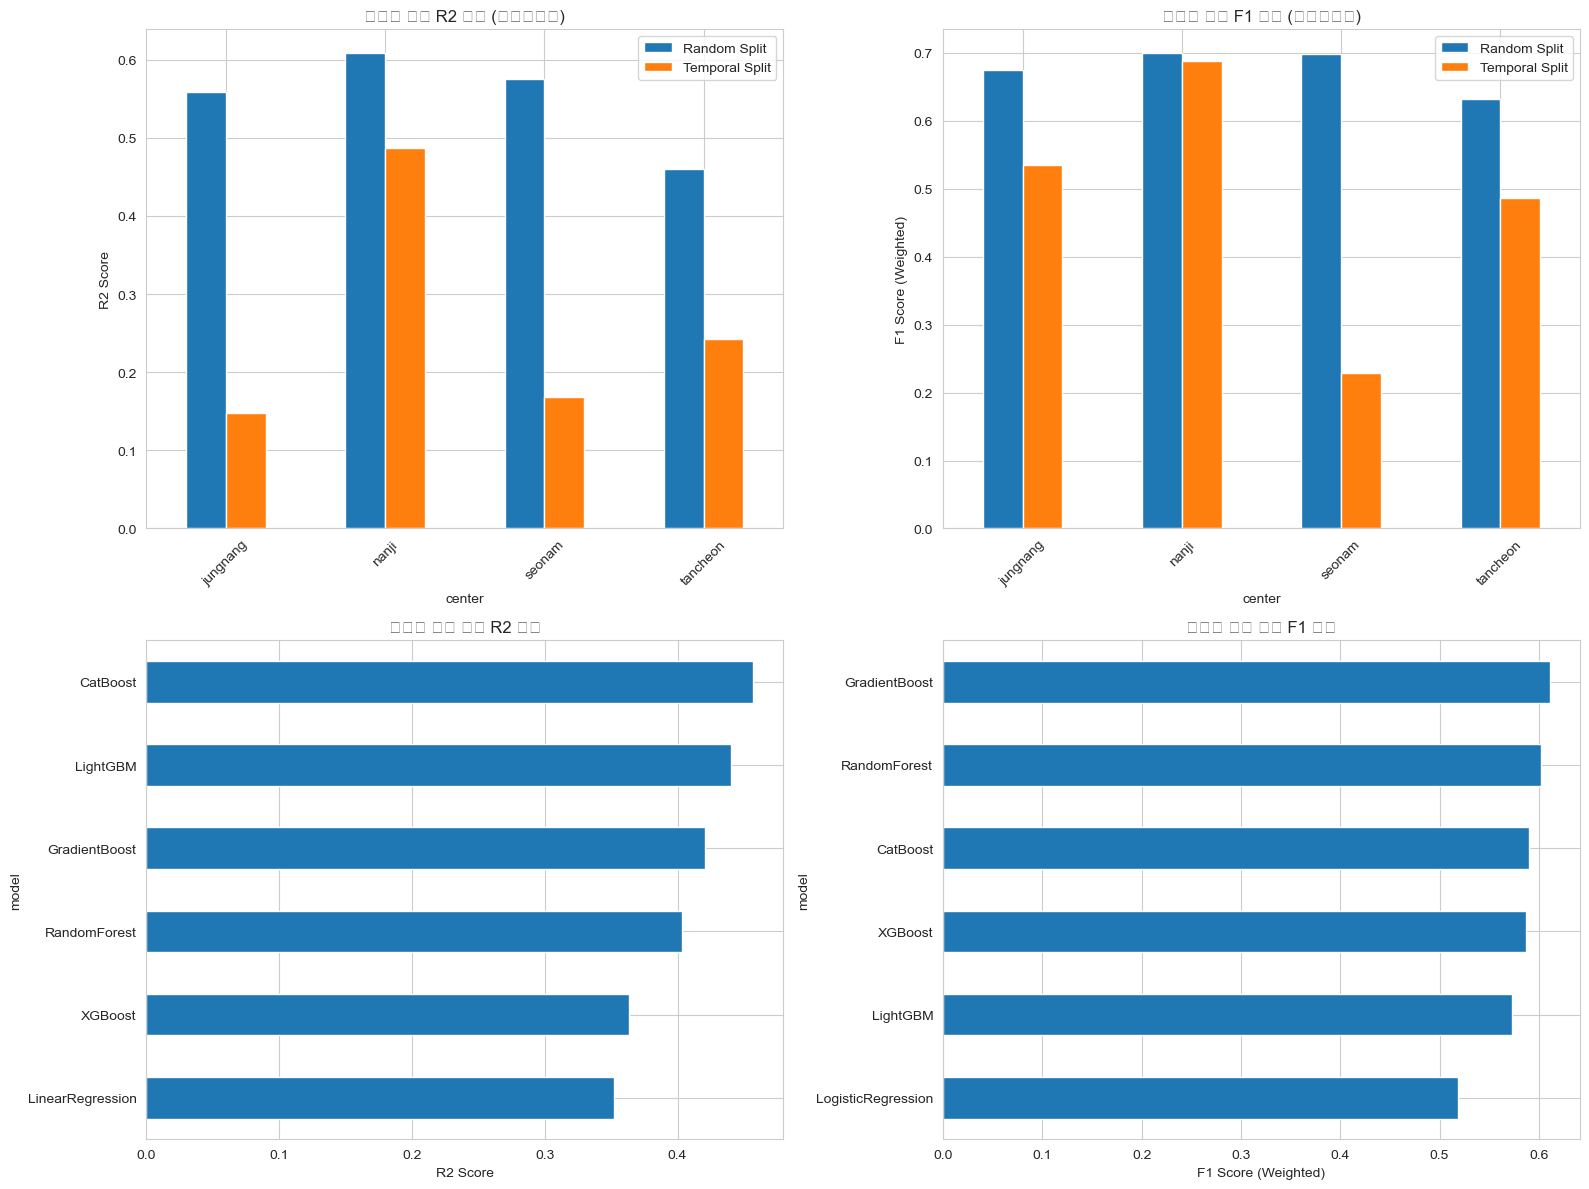

‚úÖ ÏãúÍ∞ÅÌôî ÏôÑÎ£å Î∞è Ï†ÄÏû•: ../results/visualizations/model_performance_comparison.png

üìä ÏÑ±Îä• ÏöîÏïΩ:

üèÜ ÌöåÍ∑Ä Î™®Îç∏ TOP 3 (R2 Í∏∞Ï§Ä):
  nanji - CatBoost (random): R2 = 0.6366
  nanji - GradientBoost (random): R2 = 0.6233
  seonam - CatBoost (random): R2 = 0.6136

üèÜ Î∂ÑÎ•ò Î™®Îç∏ TOP 3 (F1_weighted Í∏∞Ï§Ä):
  nanji - XGBoost (random): F1 = 0.7316
  seonam - XGBoost (random): F1 = 0.7305
  seonam - GradientBoost (random): F1 = 0.7292
üíæ Î≤†Ïä§Ìä∏ Î™®Îç∏ Ïû¨ÌïôÏäµ Î∞è Ï†ÄÏû•

üîÑ nanji - regression - CatBoost (random) Ïû¨ÌïôÏäµ Ï§ë...
‚úÖ nanji ÏÑºÌÑ∞ Îç∞Ïù¥ÌÑ∞ Î°úÎìú: (3069, 44)
‚úÖ Î™®Îç∏ Ï†ÄÏû•: ../models/best_models/nanji_regression_CatBoost_random.pkl

üîÑ nanji - classification - XGBoost (random) Ïû¨ÌïôÏäµ Ï§ë...
‚úÖ nanji ÏÑºÌÑ∞ Îç∞Ïù¥ÌÑ∞ Î°úÎìú: (3069, 44)
‚úÖ Î™®Îç∏ Ï†ÄÏû•: ../models/best_models/nanji_classification_XGBoost_random.pkl

üîÑ jungnang - regression - LightGBM (random) Ïû¨ÌïôÏäµ Ï§ë...
‚úÖ jungnang ÏÑºÌÑ∞ Îç∞Ïù¥ÌÑ∞ Î°úÎìú: (3069, 44)
‚úÖ Î™®Î

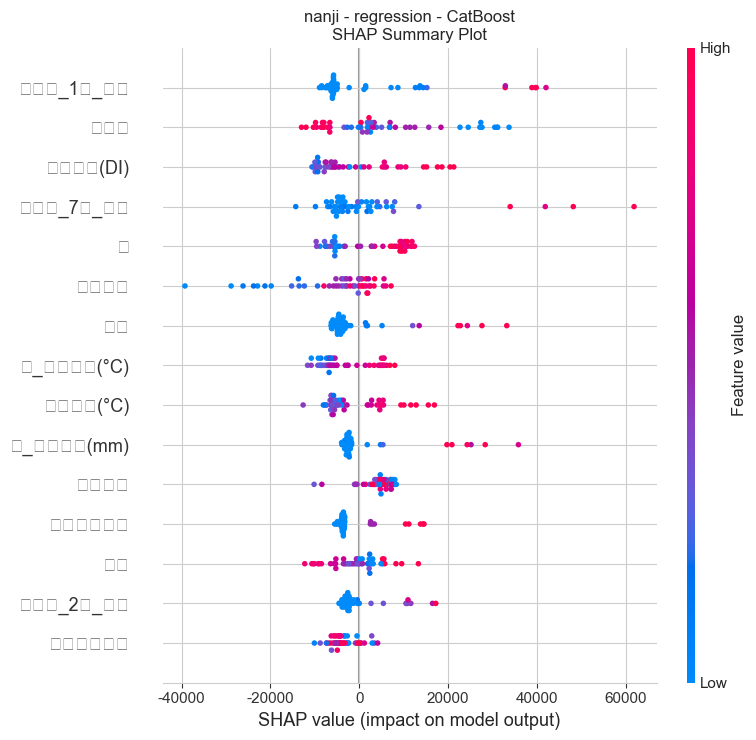

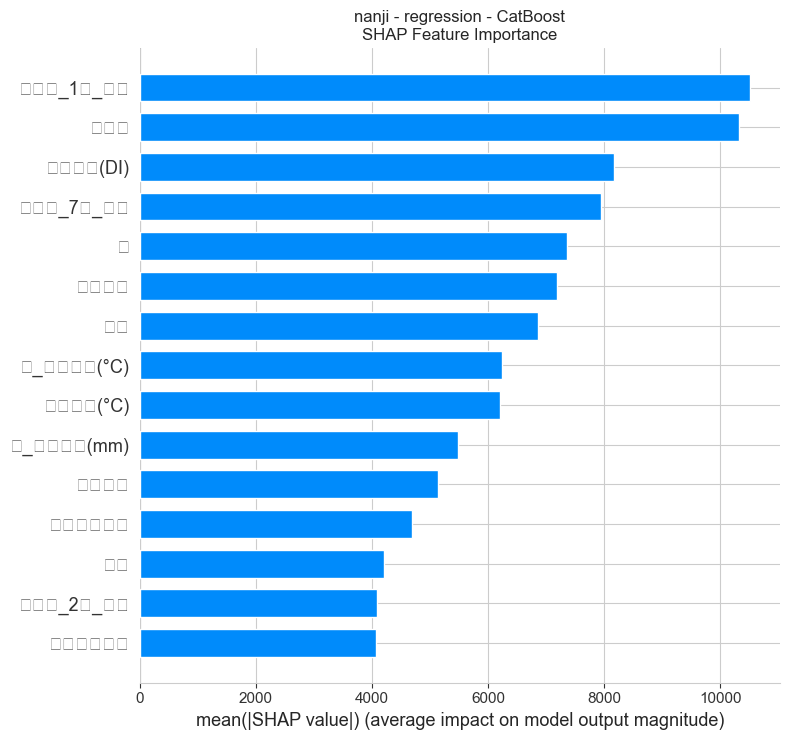

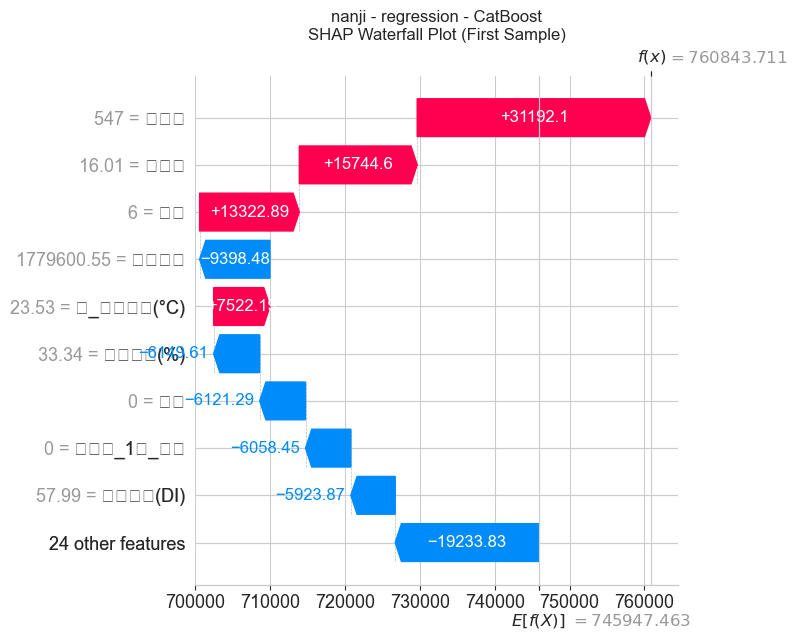

‚úÖ SHAP Î∂ÑÏÑù ÏôÑÎ£å: nanji - regression - CatBoost

üîç nanji - classification - XGBoost SHAP Î∂ÑÏÑù...


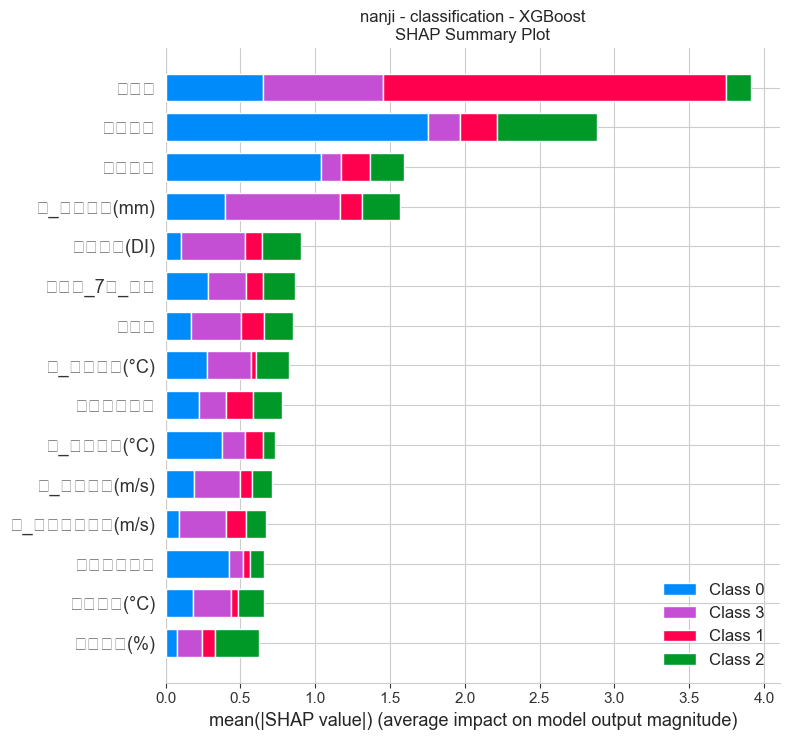

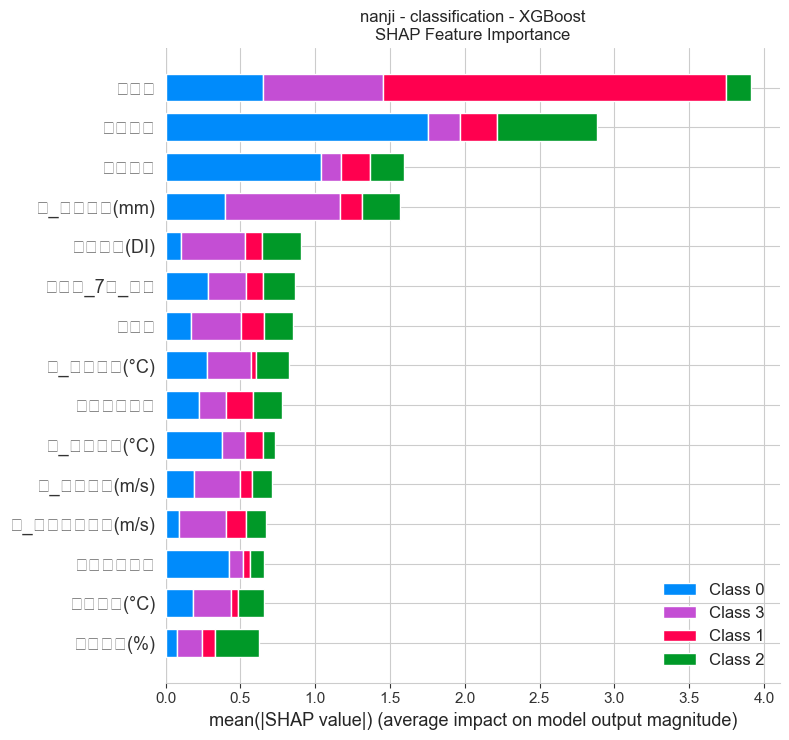

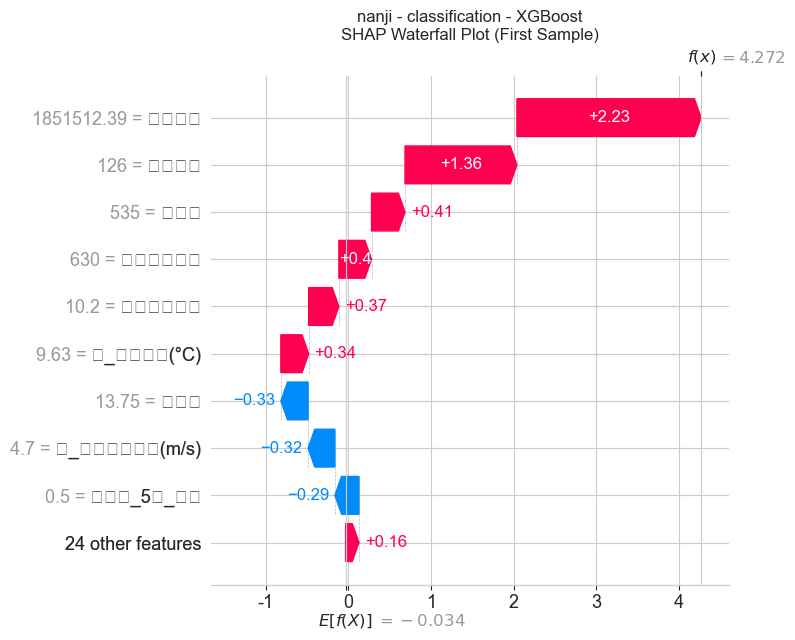

‚úÖ SHAP Î∂ÑÏÑù ÏôÑÎ£å: nanji - classification - XGBoost

üîç jungnang - regression - LightGBM SHAP Î∂ÑÏÑù...


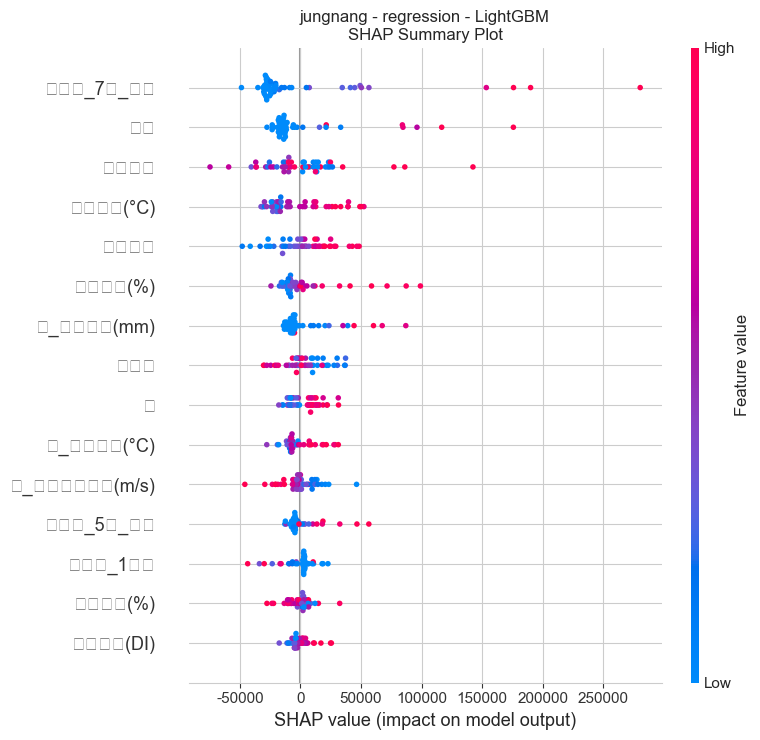

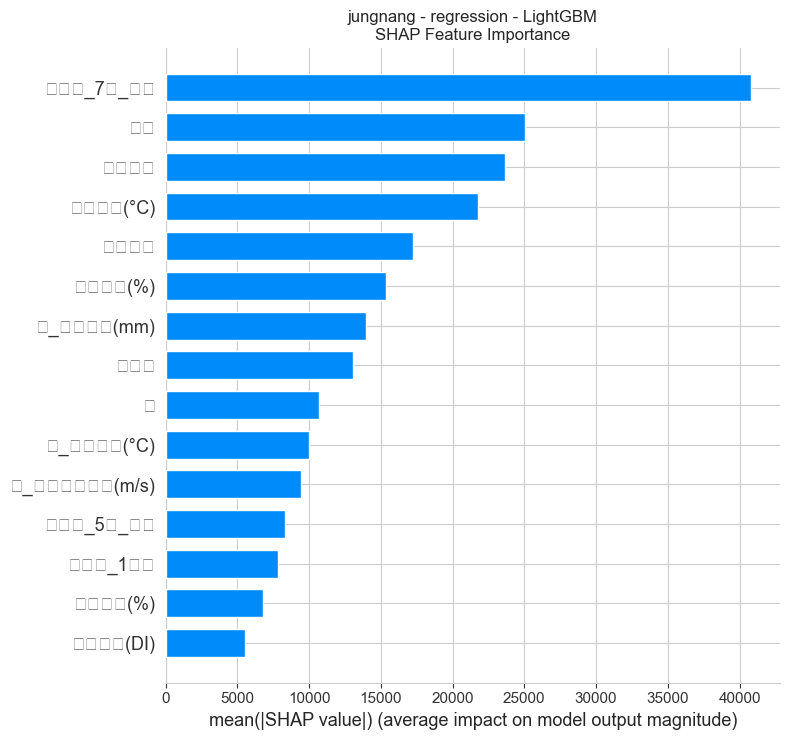

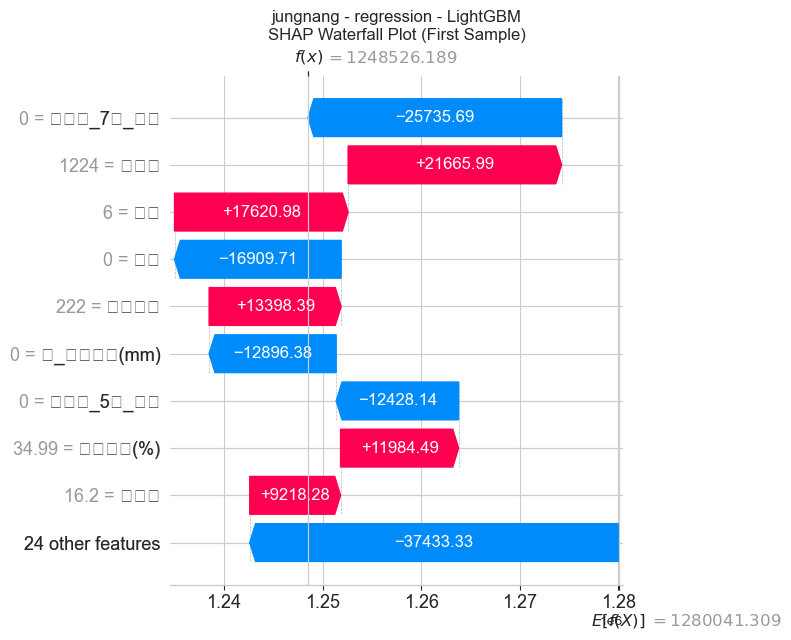

‚úÖ SHAP Î∂ÑÏÑù ÏôÑÎ£å: jungnang - regression - LightGBM

üîç jungnang - classification - LightGBM SHAP Î∂ÑÏÑù...


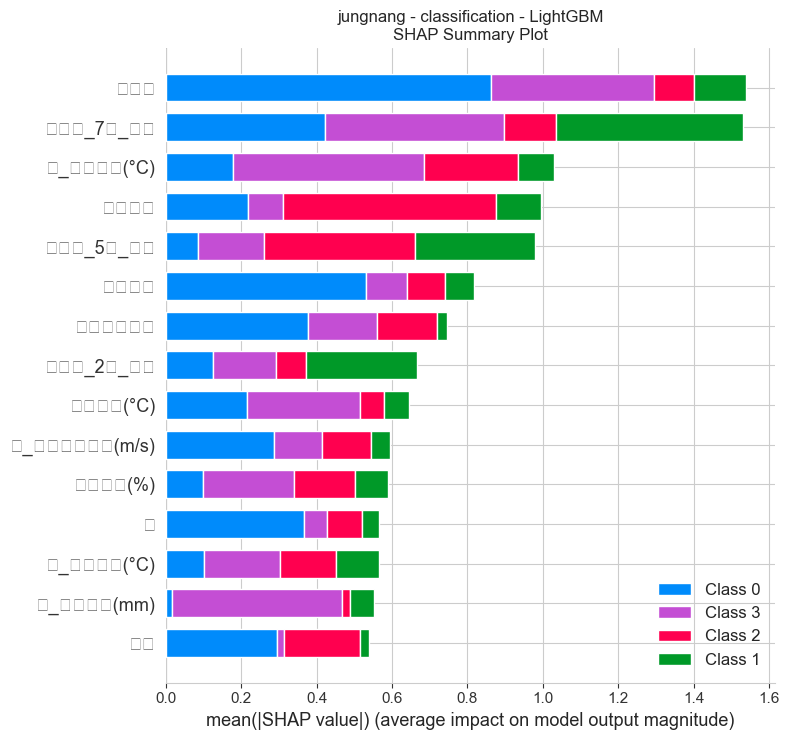

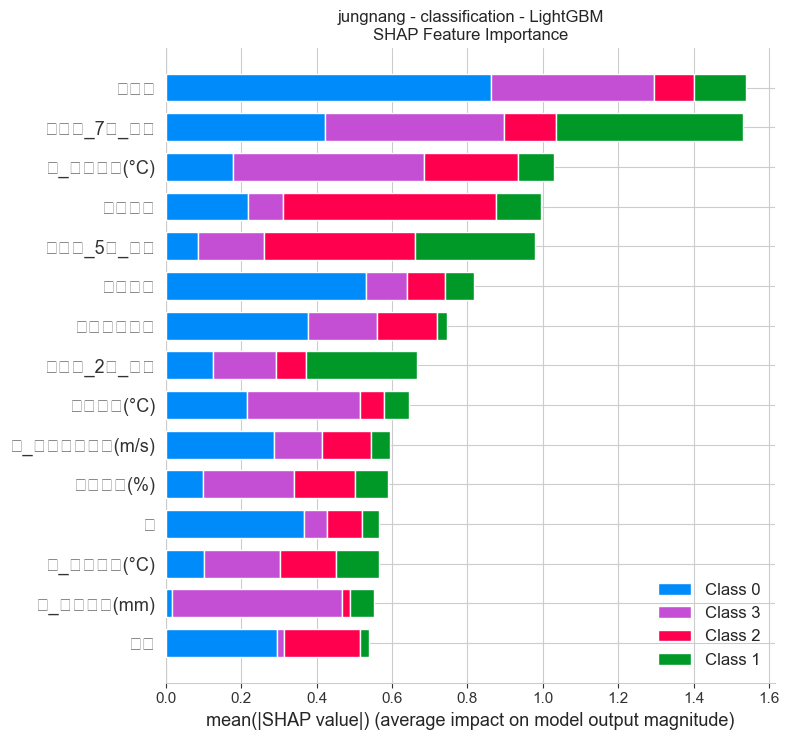

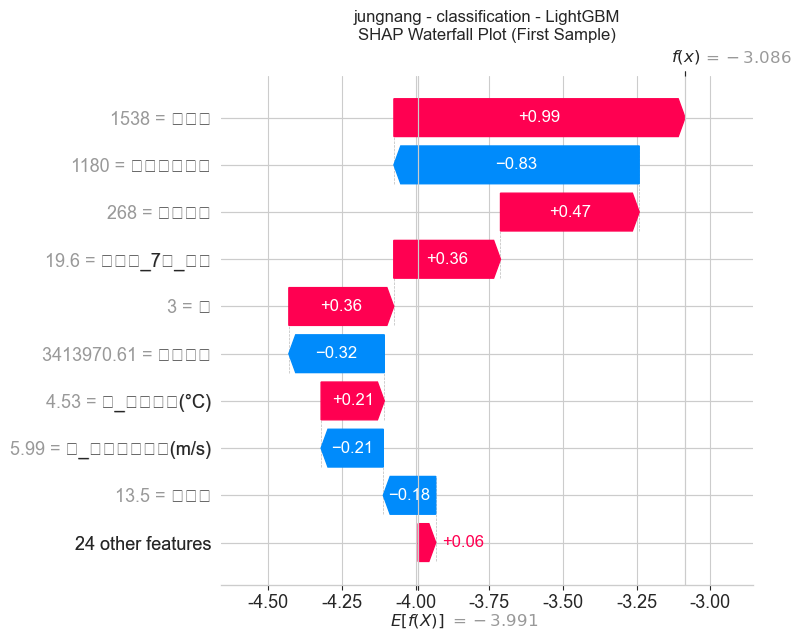

‚úÖ SHAP Î∂ÑÏÑù ÏôÑÎ£å: jungnang - classification - LightGBM

üîç seonam - regression - CatBoost SHAP Î∂ÑÏÑù...


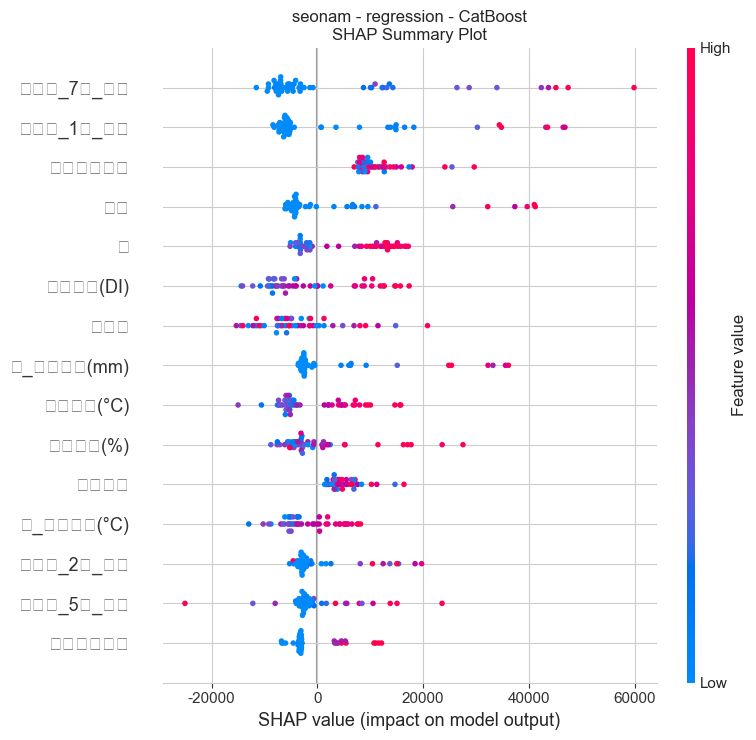

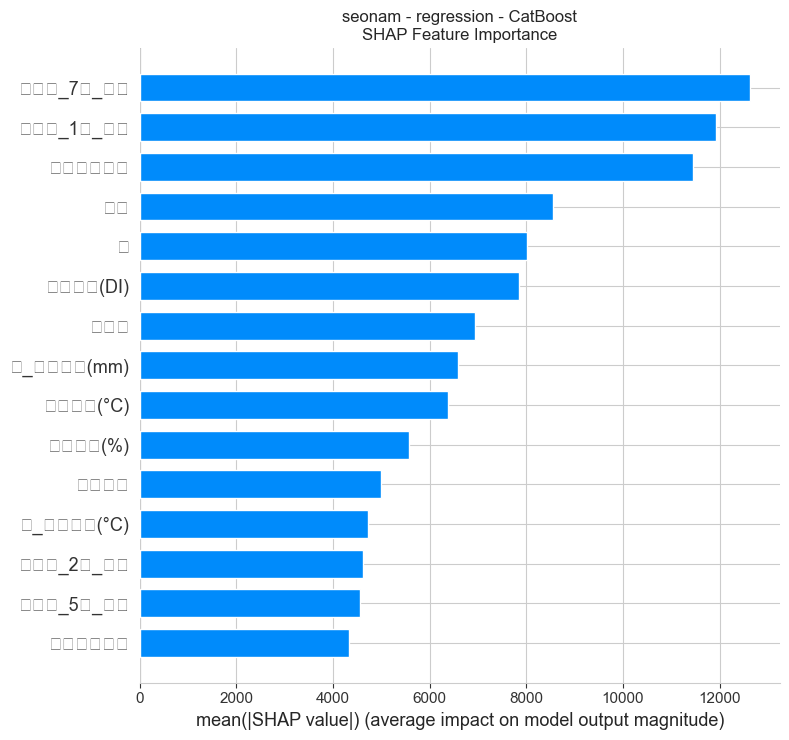

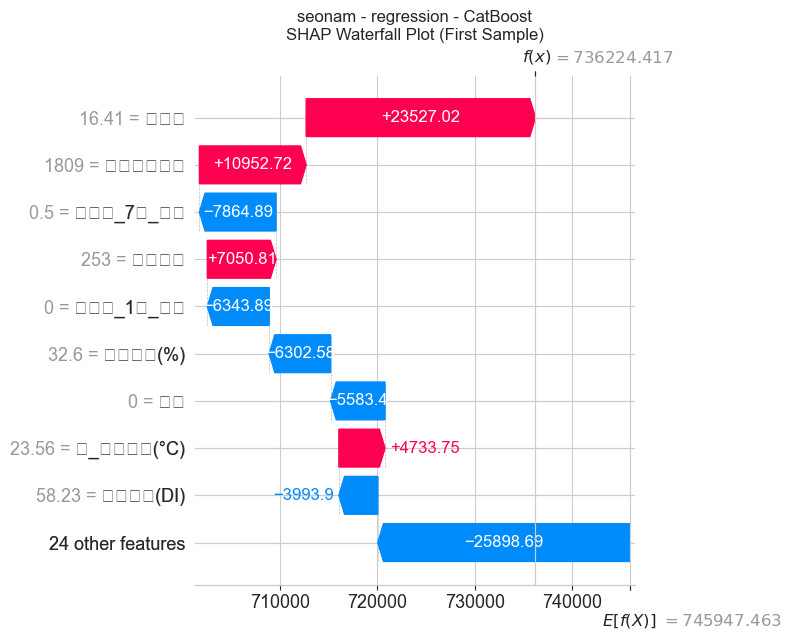

‚úÖ SHAP Î∂ÑÏÑù ÏôÑÎ£å: seonam - regression - CatBoost

üîç seonam - classification - XGBoost SHAP Î∂ÑÏÑù...


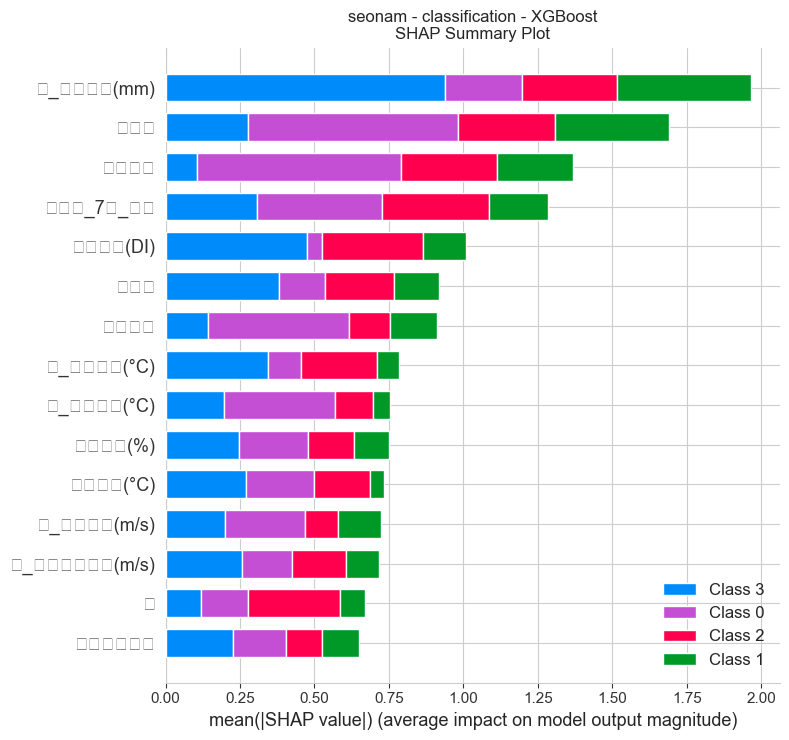

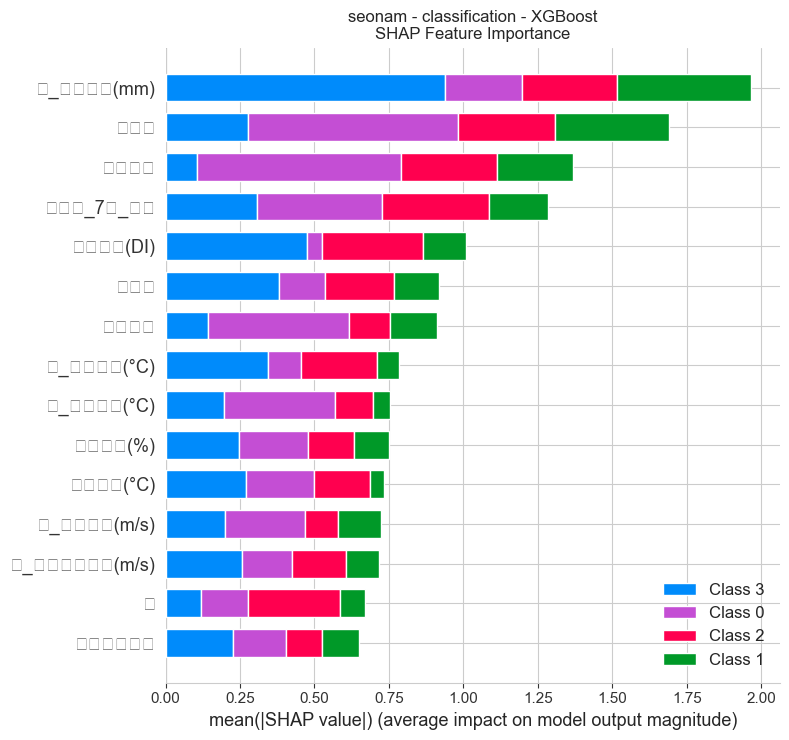

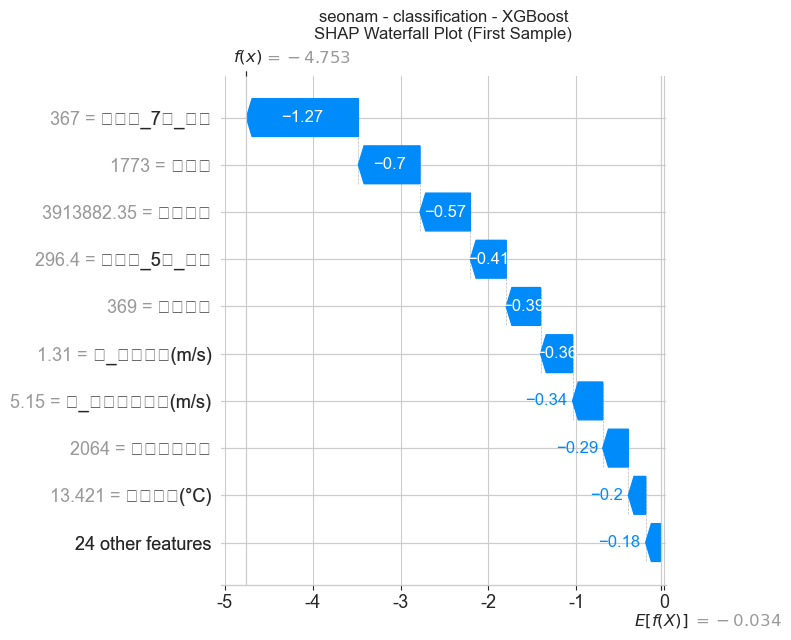

‚úÖ SHAP Î∂ÑÏÑù ÏôÑÎ£å: seonam - classification - XGBoost

üîç tancheon - regression - CatBoost SHAP Î∂ÑÏÑù...


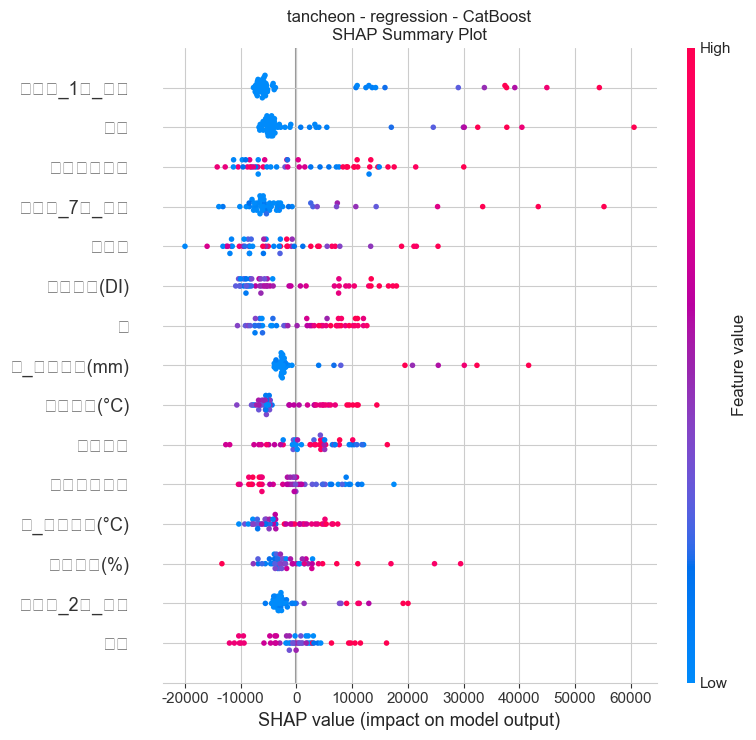

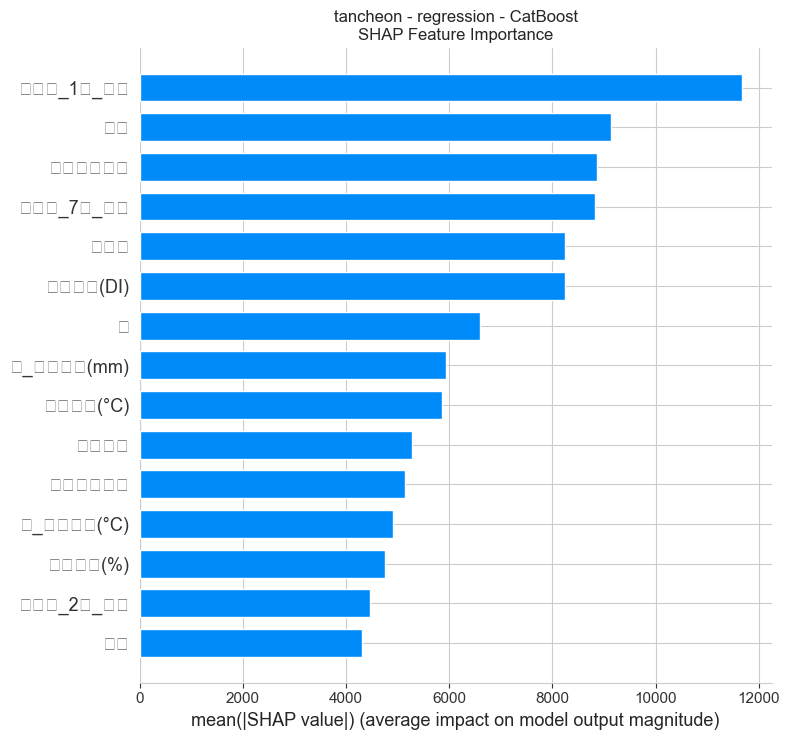

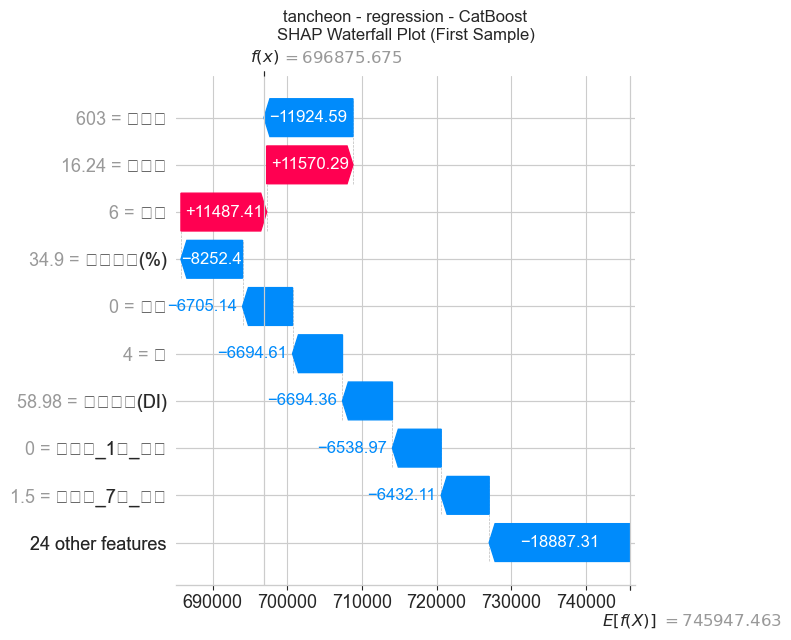

‚úÖ SHAP Î∂ÑÏÑù ÏôÑÎ£å: tancheon - regression - CatBoost

üîç tancheon - classification - LightGBM SHAP Î∂ÑÏÑù...


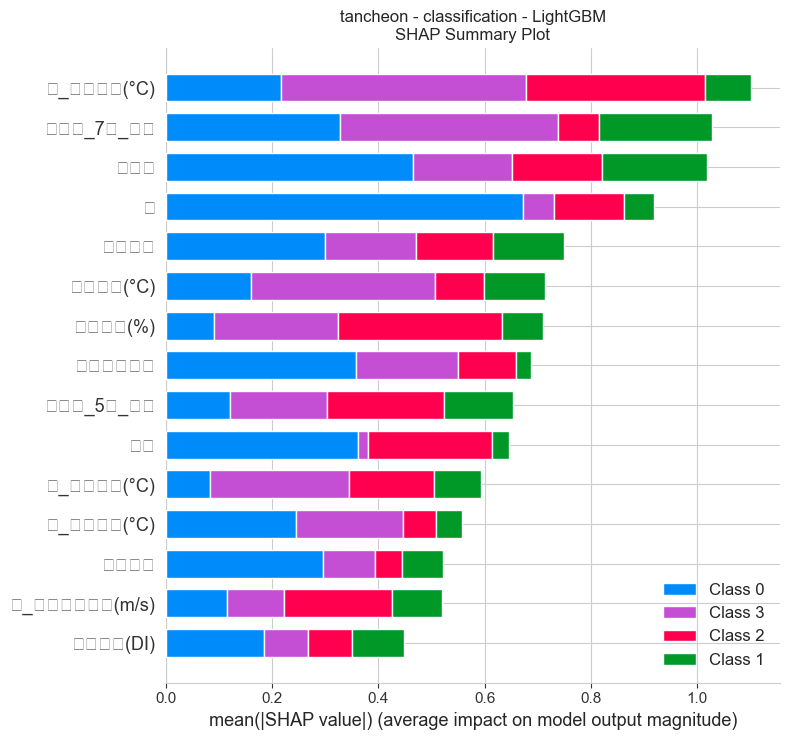

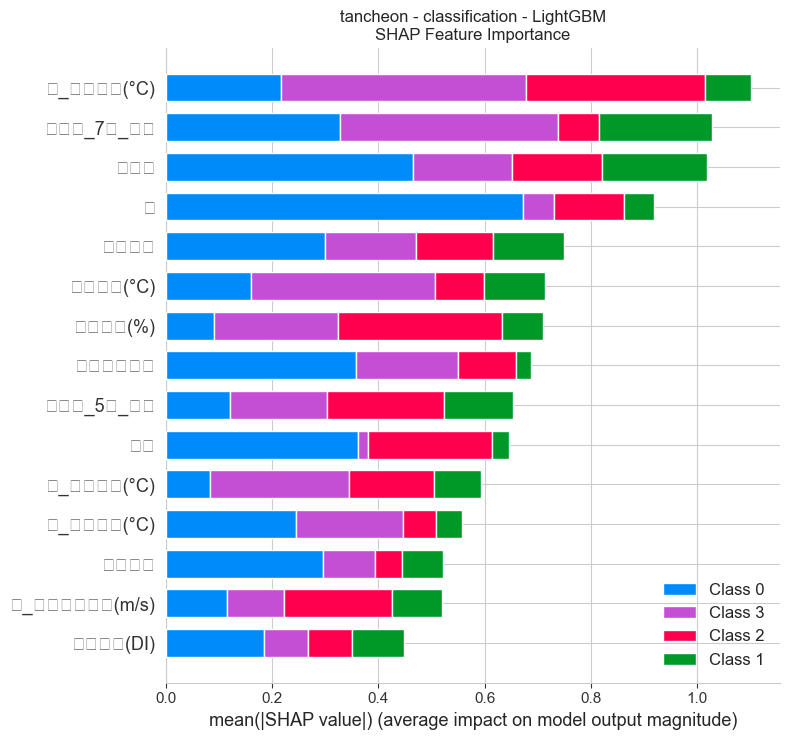

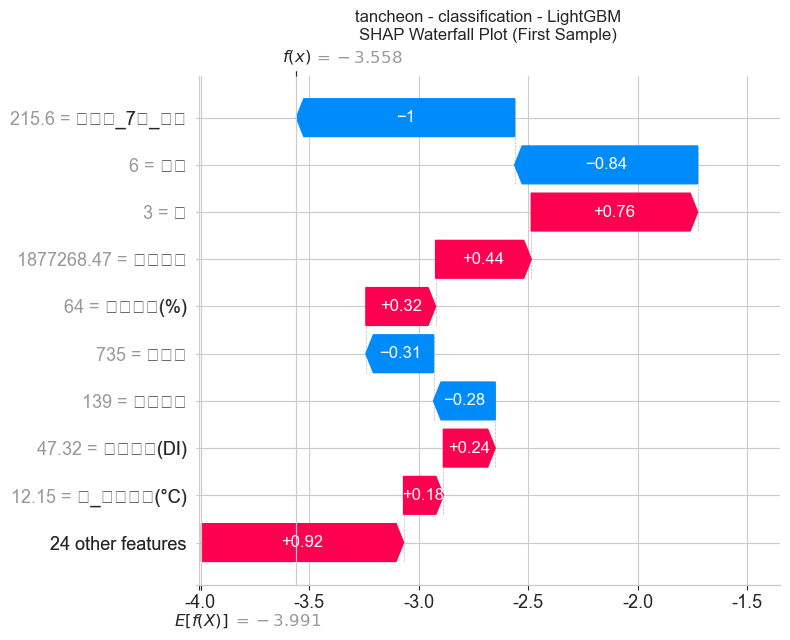

‚úÖ SHAP Î∂ÑÏÑù ÏôÑÎ£å: tancheon - classification - LightGBM
üìä Feature Importance Î∂ÑÏÑù

üìä nanji - regression - CatBoost Feature Importance...


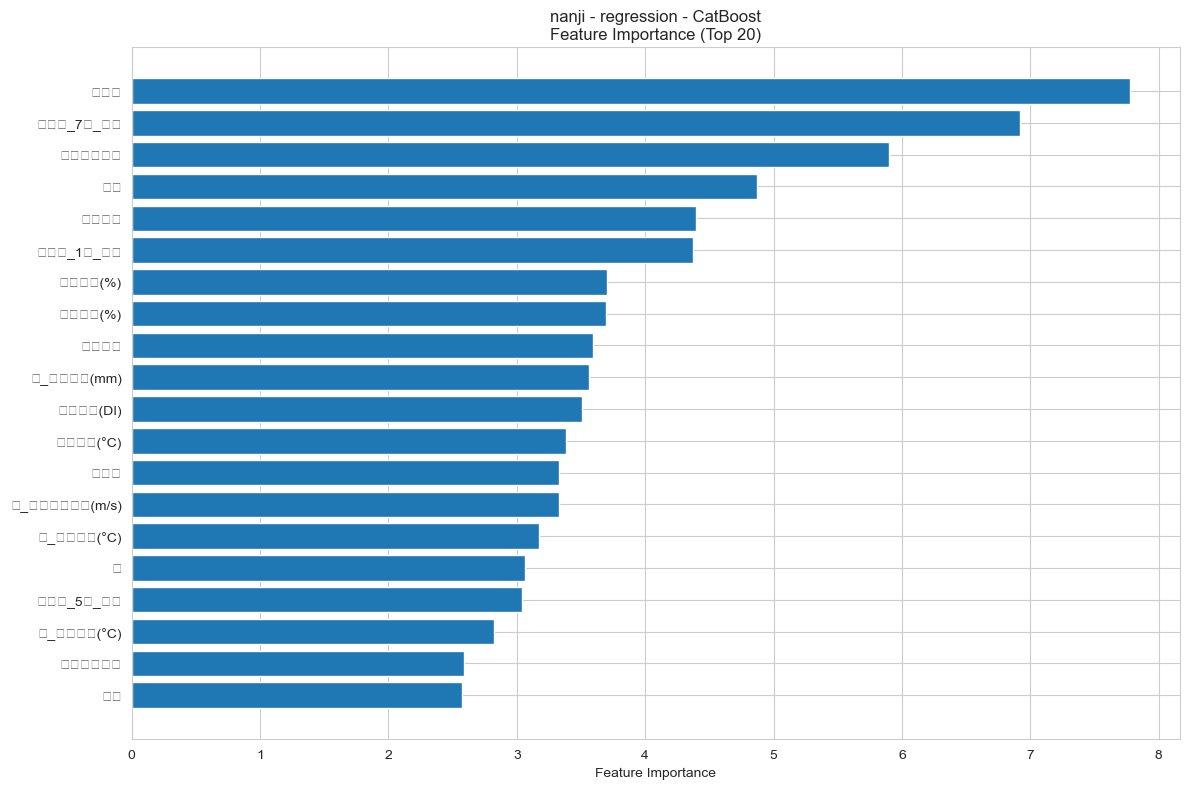

‚úÖ Feature Importance ÏôÑÎ£å: nanji - regression - CatBoost

üìä nanji - classification - XGBoost Feature Importance...


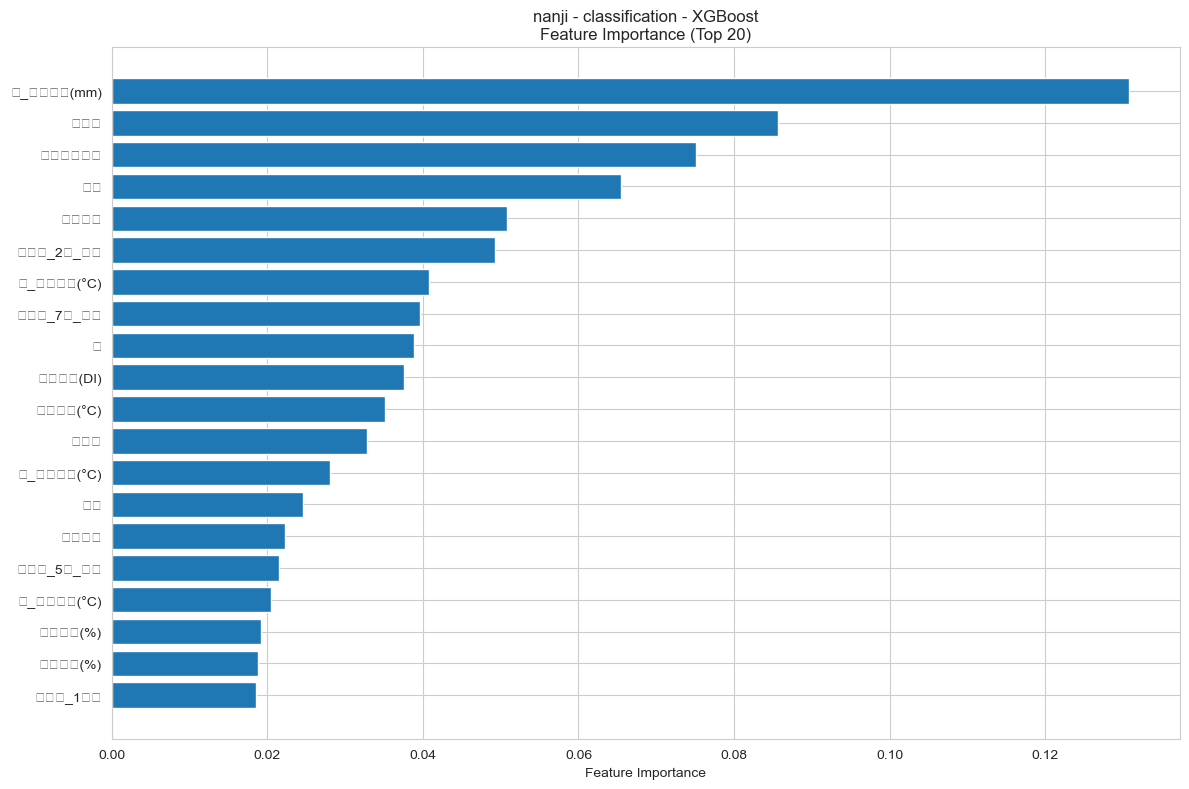

‚úÖ Feature Importance ÏôÑÎ£å: nanji - classification - XGBoost

üìä jungnang - regression - LightGBM Feature Importance...


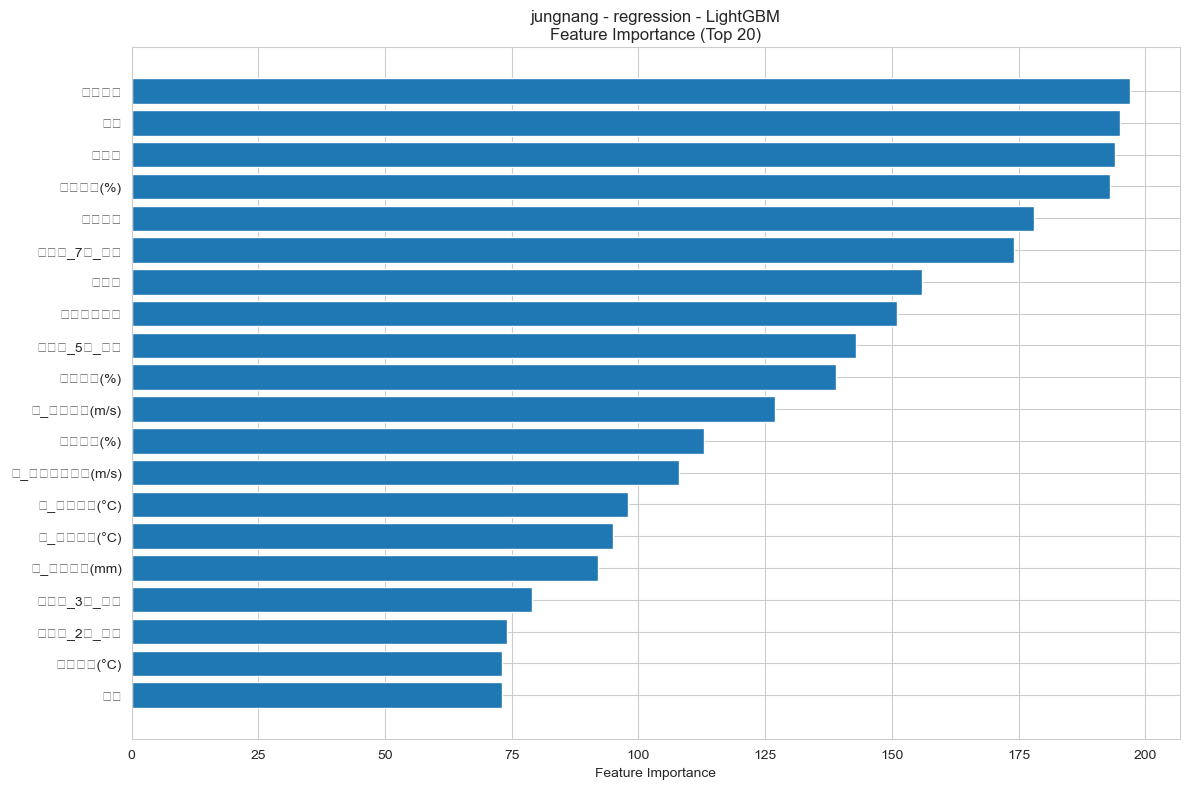

‚úÖ Feature Importance ÏôÑÎ£å: jungnang - regression - LightGBM

üìä jungnang - classification - LightGBM Feature Importance...


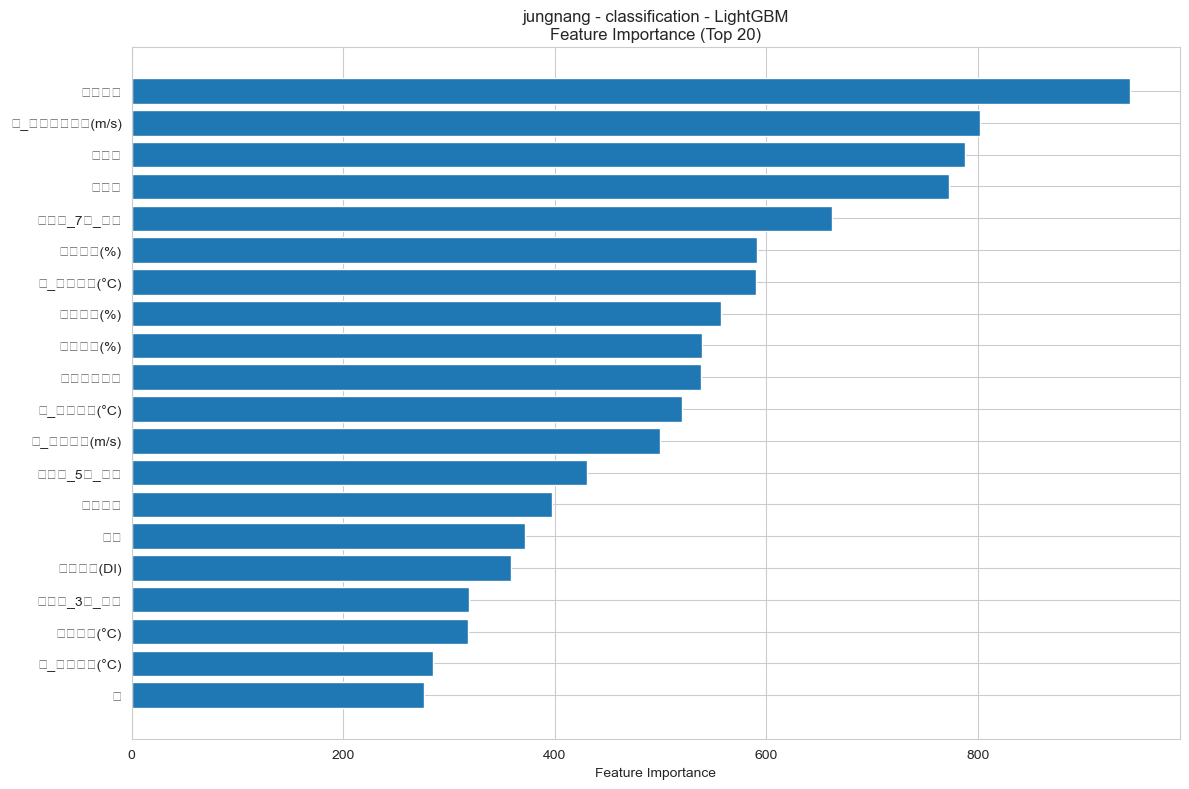

‚úÖ Feature Importance ÏôÑÎ£å: jungnang - classification - LightGBM

üìä seonam - regression - CatBoost Feature Importance...


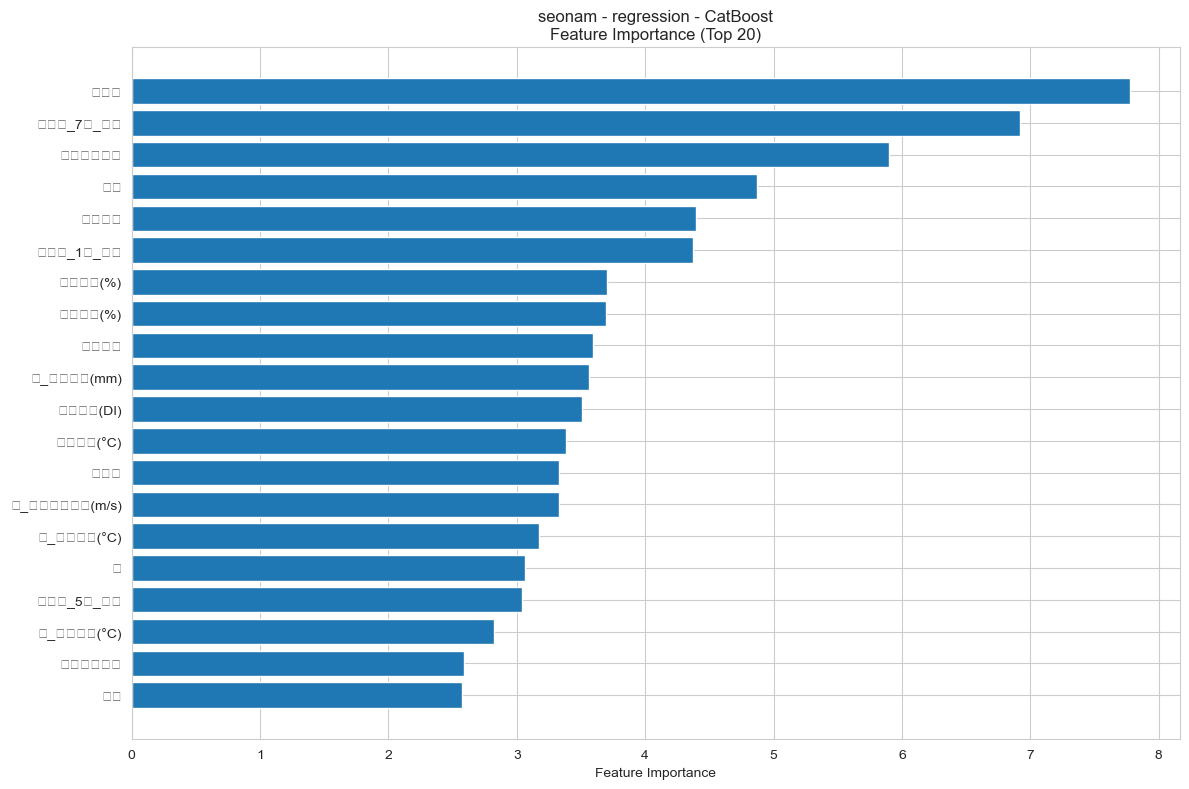

‚úÖ Feature Importance ÏôÑÎ£å: seonam - regression - CatBoost

üìä seonam - classification - XGBoost Feature Importance...


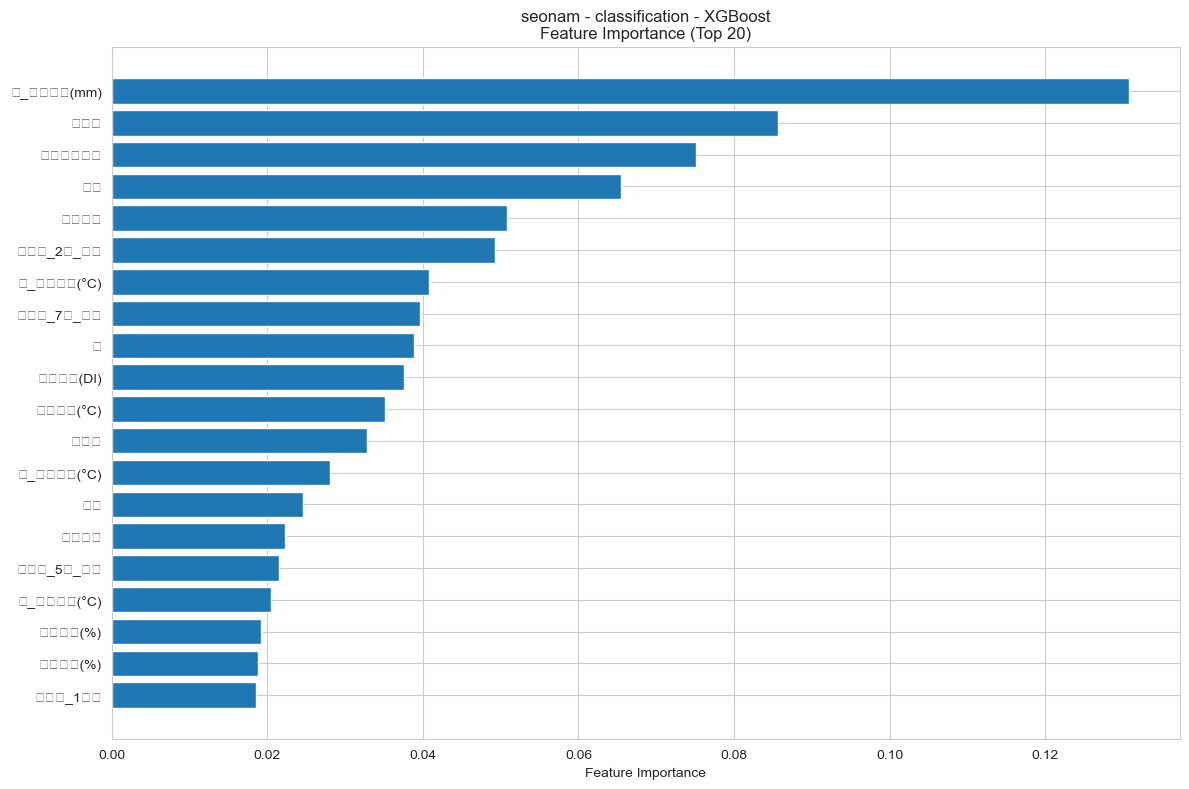

‚úÖ Feature Importance ÏôÑÎ£å: seonam - classification - XGBoost

üìä tancheon - regression - CatBoost Feature Importance...


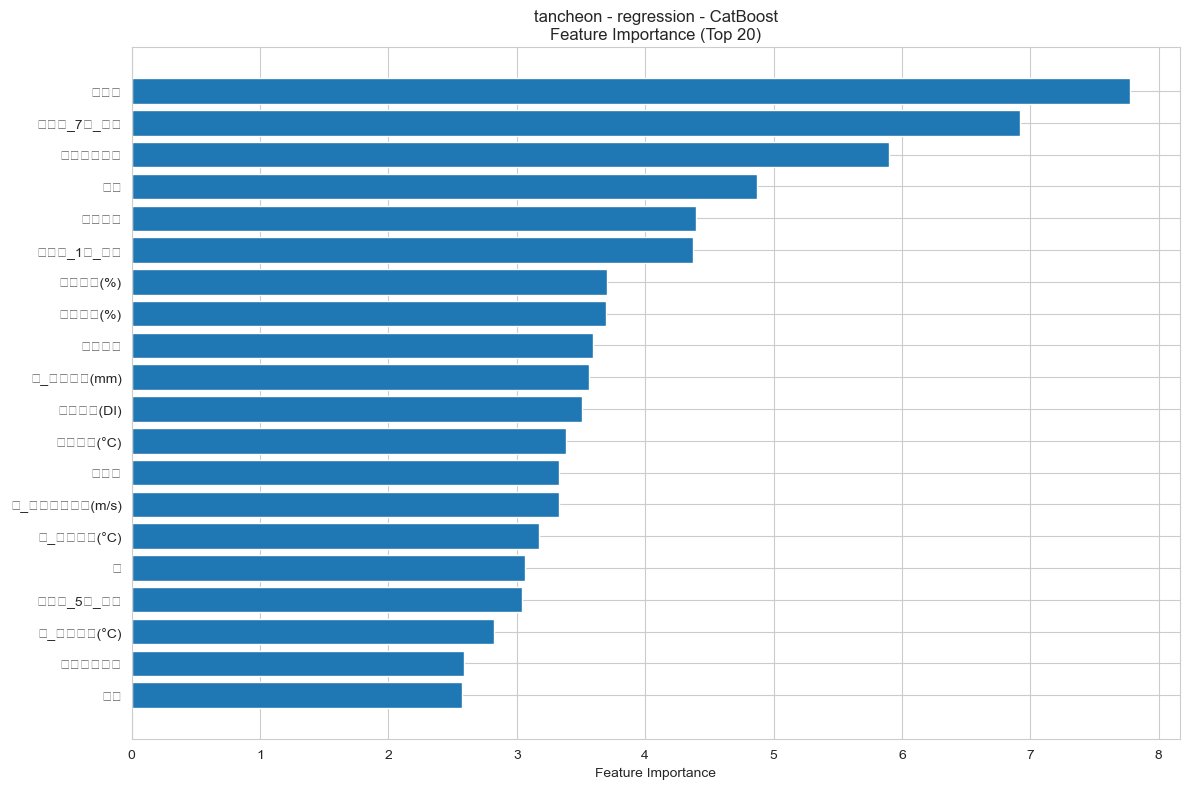

‚úÖ Feature Importance ÏôÑÎ£å: tancheon - regression - CatBoost

üìä tancheon - classification - LightGBM Feature Importance...


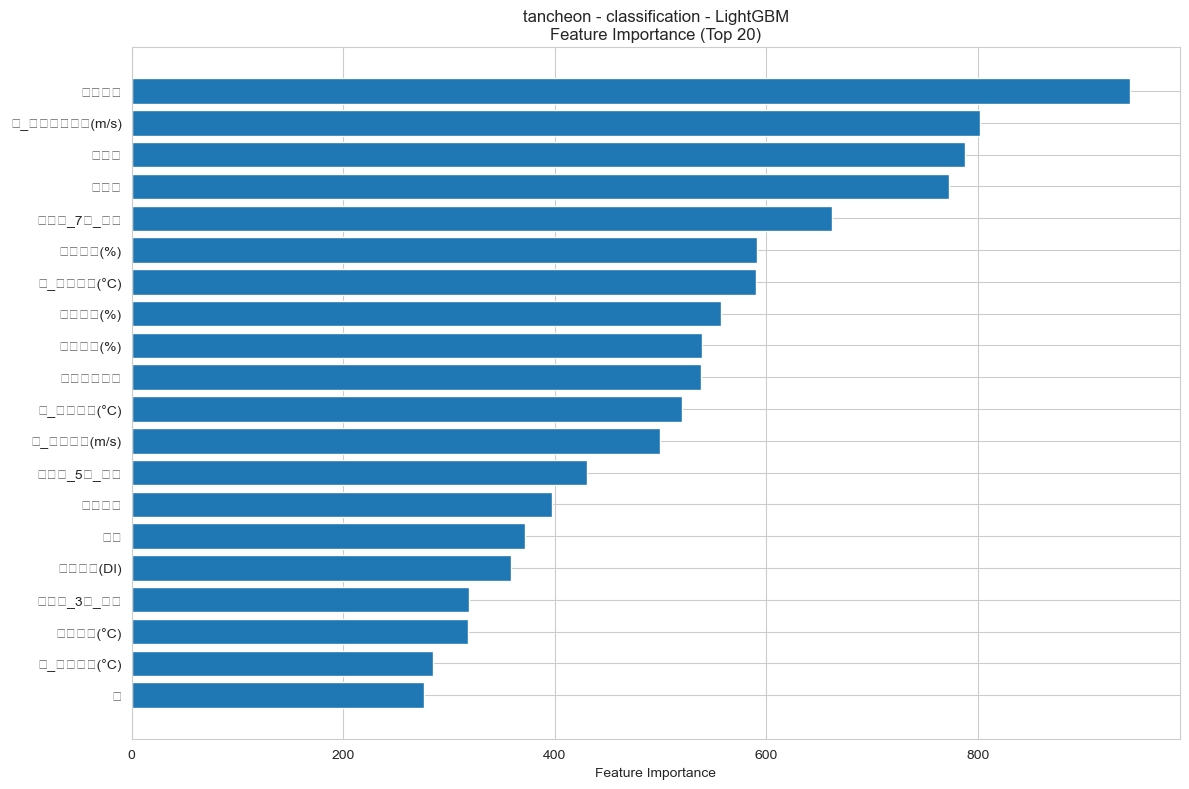

‚úÖ Feature Importance ÏôÑÎ£å: tancheon - classification - LightGBM
üçã LIME Î∂ÑÏÑù ÏãúÏûë

üçã nanji - regression - CatBoost LIME Î∂ÑÏÑù...


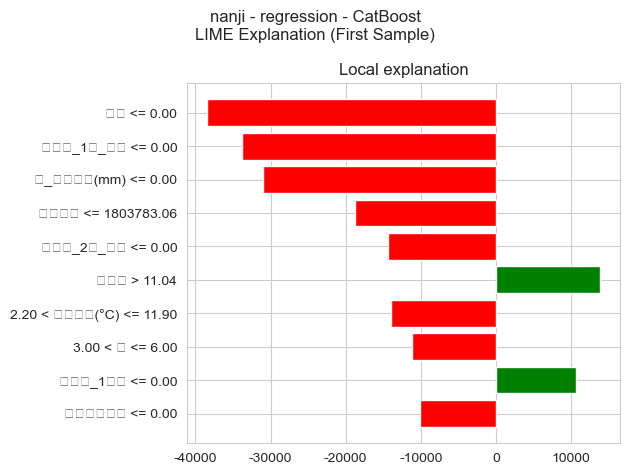

‚úÖ LIME Î∂ÑÏÑù ÏôÑÎ£å: nanji - regression - CatBoost

üçã nanji - classification - XGBoost LIME Î∂ÑÏÑù...


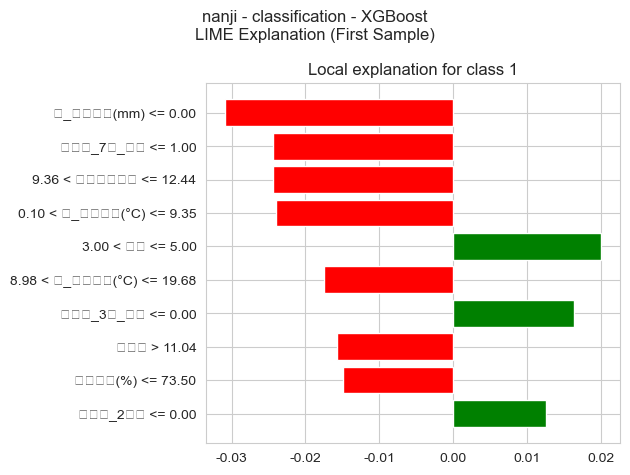

‚úÖ LIME Î∂ÑÏÑù ÏôÑÎ£å: nanji - classification - XGBoost
‚è∞ ÏãúÍ∞Ñ Ï†àÏïΩÏùÑ ÏúÑÌï¥ Ï≤òÏùå 2Í∞ú Î™®Îç∏Îßå LIME Î∂ÑÏÑùÌï©ÎãàÎã§.
üîÆ ÏòàÏ∏° Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å
üìã ÏµúÏ¢Ö Ïã§Ìñâ ÏôÑÎ£å Ï≤¥ÌÅ¨Î¶¨Ïä§Ìä∏
‚ùå 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú: ÎØ∏ÏôÑÎ£å
‚ùå 2. Î™®Îç∏ ÌïôÏäµ: ÎØ∏ÏôÑÎ£å
‚úÖ 3. Í≤∞Í≥º CSV Ï†ÄÏû•: ÏôÑÎ£å
‚úÖ 4. Î≤†Ïä§Ìä∏ Î™®Îç∏ ÏÑ†Ï†ï: ÏôÑÎ£å
‚úÖ 5. ÏÑ±Îä• ÏãúÍ∞ÅÌôî: ÏôÑÎ£å
‚úÖ 6. Î™®Îç∏ ÌååÏùº Ï†ÄÏû•: ÏôÑÎ£å
‚úÖ 7. SHAP Î∂ÑÏÑù: ÏôÑÎ£å
‚úÖ 8. Feature Importance: ÏôÑÎ£å

üìä Ï†ÑÏ≤¥ ÏôÑÎ£åÏú®: 75.0% (6/8)
‚ö†Ô∏è ÎåÄÎ∂ÄÎ∂Ñ ÏôÑÎ£åÎêòÏóàÏúºÎÇò ÏùºÎ∂Ä Îã®Í≥ÑÎ•º ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.

üìÅ ÏÉùÏÑ±Îêú ÌååÏùº ÌòÑÌô©:
  üìä Ï†ÑÏ≤¥ Î™®Îç∏ Í≤∞Í≥º: 96Í∞ú Î†àÏΩîÎìú
  üèÜ Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï†ïÎ≥¥: 8Í∞ú Î™®Îç∏
  üìà ÏãúÍ∞ÅÌôî ÌååÏùº: 1Í∞ú
  üîç Ìï¥ÏÑù Î∂ÑÏÑù ÌååÏùº: 34Í∞ú
  ü§ñ Ï†ÄÏû•Îêú Î™®Îç∏ ÌååÏùº: 8Í∞ú
    - tancheon_classification_LightGBM_random.pkl
    - nanji_classification_XGBoost_random.pkl
    - seonam_classification_XGBoost_random.pkl
    - jungnang_classification_LightGBM_random.pkl
    

In [2]:
# ========================================================================================
# ÌïòÏàòÏ≤òÎ¶¨Îüâ ÏòàÏ∏° Î™®Îç∏ÎßÅ ÌîÑÎ°úÏ†ùÌä∏ - ÏôÑÏ†ÑÌïú Jupyter Notebook Î≤ÑÏ†Ñ
# ========================================================================================

# %% [markdown]
# # ÌïòÏàòÏ≤òÎ¶¨Îüâ ÏòàÏ∏° Î™®Îç∏ÎßÅ ÌîÑÎ°úÏ†ùÌä∏ - ÏôÑÏ†ÑÌåê
# 
# ## Î™©Ìëú
# - ÏÑºÌÑ∞ÎßàÎã§ 1ÏùºÌõÑÏùò ÌïòÏàòÏ≤òÎ¶¨ÎüâÏùÑ ÌöåÍ∑Ä, Î∂ÑÎ•òÎ°ú ÏòàÏ∏°
# - 96Í∞ú Î™®Îç∏ ÌïôÏäµ Î∞è ÏÑ±Îä• ÎπÑÍµê (4Í∞ú ÏÑºÌÑ∞ √ó 2Í∞ú Î∂ÑÌï†Î∞©Î≤ï √ó 2Í∞ú ÌÉúÏä§ÌÅ¨ √ó 6Í∞ú Î™®Îç∏)
# - Î≤†Ïä§Ìä∏ Î™®Îç∏ Ìï¥ÏÑù Í∞ÄÎä•ÏÑ± Î∂ÑÏÑù (SHAP, LIME, Feature Importance)
# - Ïû¨ÏÇ¨Ïö© Í∞ÄÎä•Ìïú Î™®Îç∏ ÌååÏùº ÏÉùÏÑ±

# %% [markdown]
# ## 1. ÌôòÍ≤Ω ÏÑ§Ï†ï Î∞è Ìå®ÌÇ§ÏßÄ import

# %%
# ÌïÑÏàò ÎùºÏù¥Î∏åÎü¨Î¶¨ import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from datetime import datetime
import pickle

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
)

# Advanced ML models
import xgboost as xgb
import catboost as cb
import lightgbm as lgb

# Ìï¥ÏÑù Í∞ÄÎä•ÏÑ± Î∂ÑÏÑù
import shap

# plt.rcParams['font.family'] ='Malgun Gothic' # ÏúàÎèÑÏö∞
plt.rcParams['font.family'] ='AppleGothic' # Îß•
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

print("‚úÖ Ìå®ÌÇ§ÏßÄ import ÏôÑÎ£å")
print(f"Ïã§Ìñâ ÏãúÍ∞Ñ: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# %% [markdown]
# ## 2. ÏÑ§Ï†ï Î∞è ÌÅ¥ÎûòÏä§ Ï†ïÏùò

# %%
class SewagePredictionPipeline:
    def __init__(self, data_path_template='../data/add_feature/{}_add_feature.csv'):
        """ÌïòÏàòÏ≤òÎ¶¨Îüâ ÏòàÏ∏° Î™®Îç∏ÎßÅ ÌååÏù¥ÌîÑÎùºÏù∏"""
        self.data_path_template = data_path_template
        self.centers = ['nanji', 'jungnang', 'seonam', 'tancheon']  # üëà Ïã§Ï†ú ÏÑºÌÑ∞Î™ÖÏúºÎ°ú ÏàòÏ†ïÌïòÏÑ∏Ïöî
        
        # Ï†úÏô∏Ìï† Ïª¨Îüº Ï†ïÏùò
        self.not_use_col = [
            'ÎÇ†Ïßú',
            '1Ï≤òÎ¶¨Ïû•','2Ï≤òÎ¶¨Ïû•','Ï†ïÌôîÏ°∞','Ï§ëÍ≥ÑÌéåÌîÑÏû•','Ìï©Í≥Ñ','ÏãúÏÑ§ÌòÑÎåÄÌôî',
            '3Ï≤òÎ¶¨Ïû•','4Ï≤òÎ¶¨Ïû•','Ìï©Í≥Ñ', 'Ìï©Í≥Ñ_1ÏùºÌõÑ','Ìï©Í≥Ñ_2ÏùºÌõÑ',
            'Îì±Í∏â','Îì±Í∏â_1ÏùºÌõÑ','Îì±Í∏â_2ÏùºÌõÑ'
        ]
        
        # ÌöåÍ∑Ä Î™®Îç∏ Ï†ïÏùò
        self.regression_models = {
            'LinearRegression': LinearRegression(),
            'RandomForest': RandomForestRegressor(random_state=42, n_estimators=100),
            'XGBoost': xgb.XGBRegressor(random_state=42, eval_metric='rmse'),
            'CatBoost': cb.CatBoostRegressor(random_state=42, verbose=False),
            'GradientBoost': GradientBoostingRegressor(random_state=42),
            'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1)
        }
        
        # Î∂ÑÎ•ò Î™®Îç∏ Ï†ïÏùò
        self.classification_models = {
            'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
            'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100),
            'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
            'CatBoost': cb.CatBoostClassifier(random_state=42, verbose=False),
            'GradientBoost': GradientBoostingClassifier(random_state=42),
            'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1)
        }
        
        # Í≤∞Í≥º Ï†ÄÏû•Ïö©
        self.results = []
        self.best_models = {}
        
        # Í≤∞Í≥º ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
        directories = ['../results', '../results/visualizations', '../results/interpretations', 
                      '../models', '../models/best_models']
        for directory in directories:
            os.makedirs(directory, exist_ok=True)
    
    def load_data(self, center):
        """ÏÑºÌÑ∞Î≥Ñ Îç∞Ïù¥ÌÑ∞ Î°úÎìú"""
        file_path = self.data_path_template.format(center)
        try:
            data = pd.read_csv(file_path)
            print(f"‚úÖ {center} ÏÑºÌÑ∞ Îç∞Ïù¥ÌÑ∞ Î°úÎìú: {data.shape}")
            return data
        except FileNotFoundError:
            print(f"‚ùå ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§: {file_path}")
            return None
    
    def prepare_features(self, data):
        """ÌîºÏ≤ò Î∞è ÌÉÄÍ≤ü Ï§ÄÎπÑ"""
        available_cols = [col for col in data.columns if col not in self.not_use_col]
        X = data[available_cols]
        y_reg = data['Ìï©Í≥Ñ_1ÏùºÌõÑ']  # ÌöåÍ∑ÄÏö©
        y_clf = data['Îì±Í∏â_1ÏùºÌõÑ']  # Î∂ÑÎ•òÏö©
        return X, y_reg, y_clf
    
    def split_data_temporal(self, X, y, test_size=0.2):
        """ÏãúÍ≥ÑÏó¥ Ï†ïÎ≥¥Î•º Ïú†ÏßÄÌïú Î∂ÑÌï†"""
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        return X_train, X_test, y_train, y_test
    
    def split_data_random(self, X, y, test_size=0.2, stratify=None):
        """ÎûúÎç§ Î∂ÑÌï† (Î∂ÑÎ•òÏãú stratified)"""
        return train_test_split(X, y, test_size=test_size, stratify=stratify, random_state=42)
    
    def evaluate_regression(self, y_true, y_pred):
        """ÌöåÍ∑Ä Î™®Îç∏ ÌèâÍ∞Ä ÏßÄÌëú Í≥ÑÏÇ∞"""
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        
        # MAPE Í≥ÑÏÇ∞ (0ÏúºÎ°ú ÎÇòÎàÑÍ∏∞ Î∞©ÏßÄ)
        mask = y_true != 0
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.sum() > 0 else np.inf
        
        r2 = r2_score(y_true, y_pred)
        
        return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}
    
    def evaluate_classification(self, y_true, y_pred, y_pred_proba=None):
        """Î∂ÑÎ•ò Î™®Îç∏ ÌèâÍ∞Ä ÏßÄÌëú Í≥ÑÏÇ∞"""
        metrics = {
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision_weighted': precision_score(y_true, y_pred, average='weighted', zero_division=0),
            'Precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
            'Recall_weighted': recall_score(y_true, y_pred, average='weighted', zero_division=0),
            'Recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
            'F1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
            'F1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0)
        }
        
        # ROC AUC (Îã§Ï§ëÎ∂ÑÎ•òÏùò Í≤ΩÏö∞ ovr Î∞©Ïãù ÏÇ¨Ïö©)
        if y_pred_proba is not None:
            try:
                if len(np.unique(y_true)) == 2:
                    auc_score = roc_auc_score(y_true, y_pred_proba[:, 1])
                else:
                    auc_score = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
                metrics['AUC'] = auc_score
            except:
                metrics['AUC'] = 0
        
        return metrics

# ÌååÏù¥ÌîÑÎùºÏù∏ Ï¥àÍ∏∞Ìôî
pipeline = SewagePredictionPipeline()
print("üîß ÌååÏù¥ÌîÑÎùºÏù∏ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å")

# %% [markdown]
# ## 3. Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏

# %%
print("üìä Îç∞Ïù¥ÌÑ∞ ÌååÏùº ÌôïÏù∏")
print("="*50)

data_info = {}
for center in pipeline.centers:
    data = pipeline.load_data(center)
    if data is not None:
        data_info[center] = {
            'data': data,
            'shape': data.shape
        }
        
        # Í∏∞Î≥∏ Ï†ïÎ≥¥ Ï∂úÎ†•
        X, y_reg, y_clf = pipeline.prepare_features(data)
        print(f"  üìà ÌîºÏ≤ò Ïàò: {X.shape[1]}")
        print(f"  üéØ ÌöåÍ∑Ä ÌÉÄÍ≤ü Î≤îÏúÑ: {y_reg.min():.1f} ~ {y_reg.max():.1f}")
        print(f"  üè∑Ô∏è Î∂ÑÎ•ò ÌÉÄÍ≤ü ÌÅ¥ÎûòÏä§: {sorted(y_clf.unique())}")
        print()

if len(data_info) == 0:
    print("‚ùå Îç∞Ïù¥ÌÑ∞ ÌååÏùºÏù¥ ÏóÜÏäµÎãàÎã§. pipeline.centersÎ•º Ïã§Ï†ú ÏÑºÌÑ∞Î™ÖÏúºÎ°ú ÏàòÏ†ïÌï¥Ï£ºÏÑ∏Ïöî.")
else:
    print(f"‚úÖ {len(data_info)}Í∞ú ÏÑºÌÑ∞ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å")

# %% [markdown]
# ## 4. Ï†ÑÏ≤¥ Î™®Îç∏ ÌïôÏäµ Î∞è ÌèâÍ∞Ä

# %%
def run_all_models(pipeline):
    """Î™®Îì† ÏÑºÌÑ∞Ïùò Î™®Îì† Î™®Îç∏ ÌïôÏäµ Î∞è ÌèâÍ∞Ä"""
    print("üöÄ Ï†ÑÏ≤¥ Î™®Îç∏ ÌïôÏäµ ÏãúÏûë")
    print(f"ÏòàÏÉÅ Ï¥ù Î™®Îç∏ Ïàò: {len(pipeline.centers)} √ó 2 √ó 2 √ó 6 = {len(pipeline.centers) * 2 * 2 * 6}Í∞ú")
    print("="*80)
    
    total_models = 0
    successful_models = 0
    
    for center in pipeline.centers:
        print(f"\n{'='*60}")
        print(f"üè¢ {center.upper()} ÏÑºÌÑ∞ Ï≤òÎ¶¨ Ï§ë...")
        print(f"{'='*60}")
        
        try:
            # Îç∞Ïù¥ÌÑ∞ Î°úÎìú
            data = pipeline.load_data(center)
            if data is None:
                continue
                
            X, y_reg, y_clf = pipeline.prepare_features(data)
            
            print(f"üìä Îç∞Ïù¥ÌÑ∞ Ï†ïÎ≥¥: {X.shape[0]}Ìñâ √ó {X.shape[1]}Í∞ú ÌîºÏ≤ò")
            print(f"üéØ ÌöåÍ∑Ä ÌÉÄÍ≤ü Î≤îÏúÑ: {y_reg.min():.1f} ~ {y_reg.max():.1f}")
            print(f"üè∑Ô∏è Î∂ÑÎ•ò ÌÉÄÍ≤ü ÌÅ¥ÎûòÏä§: {sorted(y_clf.unique())}")
            
            # Îëê Í∞ÄÏßÄ Î∂ÑÌï† Î∞©Î≤ï
            for split_method in ['temporal', 'random']:
                print(f"\n--- {split_method.upper()} Î∂ÑÌï† Î∞©Î≤ï ---")
                
                # ÌöåÍ∑Ä Î™®Îç∏ ÌïôÏäµ
                print("üìà ÌöåÍ∑Ä Î™®Îç∏ ÌïôÏäµ:")
                if split_method == 'temporal':
                    X_train_reg, X_test_reg, y_train_reg, y_test_reg = pipeline.split_data_temporal(X, y_reg)
                else:
                    X_train_reg, X_test_reg, y_train_reg, y_test_reg = pipeline.split_data_random(X, y_reg)
                
                for model_name, model in pipeline.regression_models.items():
                    total_models += 1
                    try:
                        model.fit(X_train_reg, y_train_reg)
                        y_pred = model.predict(X_test_reg)
                        metrics = pipeline.evaluate_regression(y_test_reg, y_pred)
                        
                        result = {
                            'center': center, 'split_method': split_method, 'task': 'regression',
                            'model': model_name, **metrics
                        }
                        pipeline.results.append(result)
                        successful_models += 1
                        
                        print(f"  ‚úÖ {model_name}: R2={metrics['R2']:.4f}, RMSE={metrics['RMSE']:.2f}")
                        
                    except Exception as e:
                        print(f"  ‚ùå {model_name}: {str(e)}")
                
                # Î∂ÑÎ•ò Î™®Îç∏ ÌïôÏäµ
                print("üìä Î∂ÑÎ•ò Î™®Îç∏ ÌïôÏäµ:")
                if split_method == 'temporal':
                    X_train_clf, X_test_clf, y_train_clf, y_test_clf = pipeline.split_data_temporal(X, y_clf)
                else:
                    X_train_clf, X_test_clf, y_train_clf, y_test_clf = pipeline.split_data_random(X, y_clf, stratify=y_clf)
                
                for model_name, model in pipeline.classification_models.items():
                    total_models += 1
                    try:
                        model.fit(X_train_clf, y_train_clf)
                        y_pred = model.predict(X_test_clf)
                        y_pred_proba = model.predict_proba(X_test_clf) if hasattr(model, 'predict_proba') else None
                        metrics = pipeline.evaluate_classification(y_test_clf, y_pred, y_pred_proba)
                        
                        result = {
                            'center': center, 'split_method': split_method, 'task': 'classification',
                            'model': model_name, **metrics
                        }
                        pipeline.results.append(result)
                        successful_models += 1
                        
                        print(f"  ‚úÖ {model_name}: Acc={metrics['Accuracy']:.4f}, F1={metrics['F1_weighted']:.4f}")
                        
                    except Exception as e:
                        print(f"  ‚ùå {model_name}: {str(e)}")
        
        except Exception as e:
            print(f"‚ùå {center} ÏÑºÌÑ∞ Ï≤òÎ¶¨ Ïã§Ìå®: {str(e)}")
    
    print(f"\nüéâ Ï†ÑÏ≤¥ Î™®Îç∏ ÌïôÏäµ ÏôÑÎ£å!")
    print(f"ÏÑ±Í≥µ: {successful_models}/{total_models} Î™®Îç∏")
    
    # Í≤∞Í≥ºÎ•º DataFrameÏúºÎ°ú Î≥ÄÌôò
    results_df = pd.DataFrame(pipeline.results)
    results_df.to_csv('../results/all_model_results.csv', index=False, encoding='utf-8-sig')
    print(f"üíæ Í≤∞Í≥º Ï†ÄÏû•: ../results/all_model_results.csv")
    
    return results_df

# Î™®Îç∏ ÌïôÏäµ Ïã§Ìñâ
if len(data_info) > 0:
    results_df = run_all_models(pipeline)
    print("\nüìä Í≤∞Í≥º DataFrame ÏÉùÏÑ± ÏôÑÎ£å")
    if len(results_df) > 0:
        print(f"Ï¥ù Í≤∞Í≥º Ïàò: {len(results_df)}")
        print("\nÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º:")
        display(results_df.head())
else:
    print("‚ùå Îç∞Ïù¥ÌÑ∞Í∞Ä Î°úÎìúÎêòÏßÄ ÏïäÏïÑ Î™®Îç∏ ÌïôÏäµÏùÑ Í±¥ÎÑàÎúÅÎãàÎã§.")

# %% [markdown]
# ## 5. Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï∞æÍ∏∞

# %%
def find_best_models(pipeline, results_df):
    """ÏÑºÌÑ∞Î≥Ñ, ÌÉúÏä§ÌÅ¨Î≥Ñ ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏ Ï∞æÍ∏∞"""
    if len(results_df) == 0:
        print("‚ùå Î∂ÑÏÑùÌï† Í≤∞Í≥ºÍ∞Ä ÏóÜÏäµÎãàÎã§.")
        return None
    
    print("üèÜ Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï∞æÍ∏∞")
    print("="*50)
    
    best_models_list = []
    
    for center in pipeline.centers:
        for task in ['regression', 'classification']:
            center_task_data = results_df[
                (results_df['center'] == center) & 
                (results_df['task'] == task)
            ]
            
            if len(center_task_data) == 0:
                continue
            
            if task == 'regression':
                # R2Í∞Ä ÎÜíÏùÄ Î™®Îç∏ ÏÑ†ÌÉù
                best_model = center_task_data.loc[center_task_data['R2'].idxmax()]
                metric_value = best_model['R2']
                metric_name = 'R2'
            else:
                # F1_weightedÍ∞Ä ÎÜíÏùÄ Î™®Îç∏ ÏÑ†ÌÉù
                best_model = center_task_data.loc[center_task_data['F1_weighted'].idxmax()]
                metric_value = best_model['F1_weighted']
                metric_name = 'F1_weighted'
            
            best_models_list.append(best_model.to_dict())
            print(f"üèÖ {center} - {task}: {best_model['model']} ({best_model['split_method']}) - {metric_name}={metric_value:.4f}")
    
    best_models_df = pd.DataFrame(best_models_list)
    best_models_df.to_csv('../results/best_models.csv', index=False, encoding='utf-8-sig')
    print(f"\nüíæ Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï†ïÎ≥¥ Ï†ÄÏû•: ../results/best_models.csv")
    
    return best_models_df

# Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï∞æÍ∏∞ Ïã§Ìñâ
if 'results_df' in locals() and len(results_df) > 0:
    best_models_df = find_best_models(pipeline, results_df)
    if best_models_df is not None:
        print(f"\nüìã Î≤†Ïä§Ìä∏ Î™®Îç∏ ÏöîÏïΩ ({len(best_models_df)}Í∞ú):")
        display(best_models_df[['center', 'task', 'model', 'split_method', 'R2', 'F1_weighted']].fillna('-'))

# %% [markdown]
# ## 6. ÏÑ±Îä• ÏãúÍ∞ÅÌôî

# %%
def create_visualizations(results_df):
    """ÏÑ±Îä• ÏãúÍ∞ÅÌôî ÏÉùÏÑ±"""
    print("üìà ÏÑ±Îä• ÏãúÍ∞ÅÌôî ÏÉùÏÑ±")
    print("="*40)
    
    if len(results_df) == 0:
        print("‚ùå ÏãúÍ∞ÅÌôîÌï† Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. ÏÑºÌÑ∞Î≥Ñ ÌöåÍ∑Ä ÏÑ±Îä• (Î∂ÑÌï†Î∞©Î≤ïÎ≥Ñ)
    reg_data = results_df[results_df['task'] == 'regression']
    if len(reg_data) > 0:
        reg_summary = reg_data.groupby(['center', 'split_method'])['R2'].mean().unstack(fill_value=0)
        reg_summary.plot(kind='bar', ax=axes[0,0], title='ÏÑºÌÑ∞Î≥Ñ ÌöåÍ∑Ä R2 ÏÑ±Îä• (Î∂ÑÌï†Î∞©Î≤ïÎ≥Ñ)')
        axes[0,0].set_ylabel('R2 Score')
        axes[0,0].legend(['Random Split', 'Temporal Split'])
        axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. ÏÑºÌÑ∞Î≥Ñ Î∂ÑÎ•ò ÏÑ±Îä• (Î∂ÑÌï†Î∞©Î≤ïÎ≥Ñ)  
    clf_data = results_df[results_df['task'] == 'classification']
    if len(clf_data) > 0:
        clf_summary = clf_data.groupby(['center', 'split_method'])['F1_weighted'].mean().unstack(fill_value=0)
        clf_summary.plot(kind='bar', ax=axes[0,1], title='ÏÑºÌÑ∞Î≥Ñ Î∂ÑÎ•ò F1 ÏÑ±Îä• (Î∂ÑÌï†Î∞©Î≤ïÎ≥Ñ)')
        axes[0,1].set_ylabel('F1 Score (Weighted)')
        axes[0,1].legend(['Random Split', 'Temporal Split'])
        axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Î™®Îç∏Î≥Ñ ÌöåÍ∑Ä ÏÑ±Îä•
    if len(reg_data) > 0:
        reg_model_perf = reg_data.groupby(['model'])['R2'].mean().sort_values(ascending=True)
        reg_model_perf.plot(kind='barh', ax=axes[1,0], title='Î™®Îç∏Î≥Ñ ÌèâÍ∑† ÌöåÍ∑Ä R2 ÏÑ±Îä•')
        axes[1,0].set_xlabel('R2 Score')
    
    # 4. Î™®Îç∏Î≥Ñ Î∂ÑÎ•ò ÏÑ±Îä•
    if len(clf_data) > 0:
        clf_model_perf = clf_data.groupby(['model'])['F1_weighted'].mean().sort_values(ascending=True)
        clf_model_perf.plot(kind='barh', ax=axes[1,1], title='Î™®Îç∏Î≥Ñ ÌèâÍ∑† Î∂ÑÎ•ò F1 ÏÑ±Îä•')
        axes[1,1].set_xlabel('F1 Score (Weighted)')
    
    plt.tight_layout()
    plt.savefig('../results/visualizations/model_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("‚úÖ ÏãúÍ∞ÅÌôî ÏôÑÎ£å Î∞è Ï†ÄÏû•: ../results/visualizations/model_performance_comparison.png")
    
    # ÏÑ±Îä• ÏöîÏïΩ Ï∂úÎ†•
    print("\nüìä ÏÑ±Îä• ÏöîÏïΩ:")
    
    # ÌöåÍ∑Ä Î™®Îç∏ ÏµúÍ≥† ÏÑ±Îä•
    if len(reg_data) > 0:
        reg_best = reg_data.nlargest(3, 'R2')
        print(f"\nüèÜ ÌöåÍ∑Ä Î™®Îç∏ TOP 3 (R2 Í∏∞Ï§Ä):")
        for idx, row in reg_best.iterrows():
            print(f"  {row['center']} - {row['model']} ({row['split_method']}): R2 = {row['R2']:.4f}")
    
    # Î∂ÑÎ•ò Î™®Îç∏ ÏµúÍ≥† ÏÑ±Îä•  
    if len(clf_data) > 0:
        clf_best = clf_data.nlargest(3, 'F1_weighted')
        print(f"\nüèÜ Î∂ÑÎ•ò Î™®Îç∏ TOP 3 (F1_weighted Í∏∞Ï§Ä):")
        for idx, row in clf_best.iterrows():
            print(f"  {row['center']} - {row['model']} ({row['split_method']}): F1 = {row['F1_weighted']:.4f}")

# ÏãúÍ∞ÅÌôî Ïã§Ìñâ
if 'results_df' in locals():
    create_visualizations(results_df)

# %% [markdown]
# ## 7. Î≤†Ïä§Ìä∏ Î™®Îç∏ Ïû¨ÌïôÏäµ Î∞è Ï†ÄÏû•

# %%
def train_and_save_best_models(pipeline, best_models_df):
    """Î≤†Ïä§Ìä∏ Î™®Îç∏Îì§ Ïû¨ÌïôÏäµ Î∞è Ï†ÄÏû•"""
    if best_models_df is None or len(best_models_df) == 0:
        print("‚ùå Ï†ÄÏû•Ìï† Î≤†Ïä§Ìä∏ Î™®Îç∏Ïù¥ ÏóÜÏäµÎãàÎã§.")
        return {}
    
    print("üíæ Î≤†Ïä§Ìä∏ Î™®Îç∏ Ïû¨ÌïôÏäµ Î∞è Ï†ÄÏû•")
    print("="*50)
    
    saved_models = {}
    
    for idx, model_info in best_models_df.iterrows():
        center = model_info['center']
        task = model_info['task']
        model_name = model_info['model']
        split_method = model_info['split_method']
        
        print(f"\nüîÑ {center} - {task} - {model_name} ({split_method}) Ïû¨ÌïôÏäµ Ï§ë...")
        
        try:
            # Îç∞Ïù¥ÌÑ∞ Î°úÎìú
            data = pipeline.load_data(center)
            if data is None:
                continue
                
            X, y_reg, y_clf = pipeline.prepare_features(data)
            y = y_reg if task == 'regression' else y_clf
            
            # Î™®Îç∏ ÏÑ†ÌÉù
            if task == 'regression':
                if model_name in pipeline.regression_models:
                    model = pipeline.regression_models[model_name]
                else:
                    print(f"‚ùå Î™®Îç∏ÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§: {model_name}")
                    continue
            else:
                if model_name in pipeline.classification_models:
                    model = pipeline.classification_models[model_name]
                else:
                    print(f"‚ùå Î™®Îç∏ÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§: {model_name}")
                    continue
            
            # Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
            if split_method == 'temporal':
                X_train, X_test, y_train, y_test = pipeline.split_data_temporal(X, y)
            else:
                stratify = y if task == 'classification' else None
                X_train, X_test, y_train, y_test = pipeline.split_data_random(X, y, stratify=stratify)
            
            # Î™®Îç∏ ÌïôÏäµ
            model.fit(X_train, y_train)
            
            # Î™®Îç∏ Ï†ÄÏû• Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
            model_data = {
                'model': model,
                'feature_names': X.columns.tolist(),
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test,
                'task': task,
                'center': center,
                'split_method': split_method,
                'model_name': model_name,
                'performance': model_info.to_dict()
            }
            
            # ÌååÏùº Ï†ÄÏû•
            filename = f"{center}_{task}_{model_name}_{split_method}.pkl"
            filepath = f"../models/best_models/{filename}"
            
            with open(filepath, 'wb') as f:
                pickle.dump(model_data, f)
            
            print(f"‚úÖ Î™®Îç∏ Ï†ÄÏû•: {filepath}")
            
            # Î©îÎ™®Î¶¨ÏóêÎèÑ Ï†ÄÏû•
            key = f"{center}_{task}"
            saved_models[key] = model_data
            
        except Exception as e:
            print(f"‚ùå {center} - {task} - {model_name} Ï†ÄÏû• Ïã§Ìå®: {str(e)}")
    
    print(f"\n‚úÖ {len(saved_models)}Í∞ú Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å")
    return saved_models

# Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï†ÄÏû• Ïã§Ìñâ
if 'best_models_df' in locals():
    saved_models = train_and_save_best_models(pipeline, best_models_df)
    print(f"ü§ñ Ï†ÄÏû•Îêú Î™®Îç∏ Ïàò: {len(saved_models)}")

# %% [markdown]
# ## 8. SHAP Î∂ÑÏÑù

# %%
def analyze_shap(saved_models):
    """SHAP Î∂ÑÏÑù Ïã§Ìñâ"""
    if len(saved_models) == 0:
        print("‚ùå Î∂ÑÏÑùÌï† Ï†ÄÏû•Îêú Î™®Îç∏Ïù¥ ÏóÜÏäµÎãàÎã§.")
        return
    
    print("üîç SHAP Î∂ÑÏÑù ÏãúÏûë")
    print("="*50)
    
    for key, model_data in saved_models.items():
        center = model_data['center']
        task = model_data['task']
        model_name = model_data['model_name']
        model = model_data['model']
        X_train = model_data['X_train']
        X_test = model_data['X_test']
        feature_names = model_data['feature_names']
        
        print(f"\nüîç {center} - {task} - {model_name} SHAP Î∂ÑÏÑù...")
        
        try:
            # SHAP explainer ÏÉùÏÑ± (ÏãúÍ∞Ñ Îã®Ï∂ïÏùÑ ÏúÑÌï¥ ÏÉòÌîå Ïàò Ï†úÌïú)
            sample_size = min(50, len(X_test))
            X_test_sample = X_test.iloc[:sample_size]
            
            if model_name in ['XGBoost', 'LightGBM', 'CatBoost']:
                explainer = shap.Explainer(model)
                shap_values = explainer(X_test_sample)
            else:
                train_sample_size = min(100, len(X_train))
                explainer = shap.Explainer(model, X_train.iloc[:train_sample_size])
                shap_values = explainer(X_test_sample)
            
            # 1. Summary Plot
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, 
                            show=False, max_display=15)
            plt.title(f'{center} - {task} - {model_name}\nSHAP Summary Plot')
            plt.tight_layout()
            plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_shap_summary.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            # 2. Feature Importance
            plt.figure(figsize=(10, 6))
            shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, 
                            plot_type="bar", show=False, max_display=15)
            plt.title(f'{center} - {task} - {model_name}\nSHAP Feature Importance')
            plt.tight_layout()
            plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_shap_importance.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            # 3. Waterfall Plot (Ï≤´ Î≤àÏß∏ ÏÉòÌîå)
            plt.figure(figsize=(12, 6))
            try:
                if hasattr(shap_values, 'values'):
                    if len(shap_values.values.shape) == 3:  # Îã§Ï§ëÎ∂ÑÎ•ò
                        shap.waterfall_plot(shap_values[0, :, 0], show=False)
                    else:
                        shap.waterfall_plot(shap_values[0], show=False)
                else:
                    shap.waterfall_plot(shap_values[0], show=False)
            except:
                # Waterfall plotÏù¥ Ïã§Ìå®ÌïòÎ©¥ Í±¥ÎÑàÎõ∞Í∏∞
                plt.text(0.5, 0.5, 'Waterfall plot not available for this model', 
                        ha='center', va='center', transform=plt.gca().transAxes)
            
            plt.title(f'{center} - {task} - {model_name}\nSHAP Waterfall Plot (First Sample)')
            plt.tight_layout()
            plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_shap_waterfall.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            print(f"‚úÖ SHAP Î∂ÑÏÑù ÏôÑÎ£å: {center} - {task} - {model_name}")
            
        except Exception as e:
            print(f"‚ùå SHAP Î∂ÑÏÑù Ïã§Ìå®: {center} - {task} - {model_name}, Ïò§Î•ò: {str(e)}")

# SHAP Î∂ÑÏÑù Ïã§Ìñâ
if 'saved_models' in locals():
    analyze_shap(saved_models)

# %% [markdown]
# ## 9. Feature Importance Î∂ÑÏÑù

# %%
def analyze_feature_importance(saved_models):
    """Feature Importance Î∂ÑÏÑù Ïã§Ìñâ"""
    if len(saved_models) == 0:
        print("‚ùå Î∂ÑÏÑùÌï† Ï†ÄÏû•Îêú Î™®Îç∏Ïù¥ ÏóÜÏäµÎãàÎã§.")
        return
    
    print("üìä Feature Importance Î∂ÑÏÑù")
    print("="*50)
    
    for key, model_data in saved_models.items():
        center = model_data['center']
        task = model_data['task']
        model_name = model_data['model_name']
        model = model_data['model']
        feature_names = model_data['feature_names']
        
        print(f"\nüìä {center} - {task} - {model_name} Feature Importance...")
        
        try:
            plt.figure(figsize=(12, 8))
            
            if hasattr(model, 'feature_importances_'):
                # Tree-based Î™®Îç∏
                importance = model.feature_importances_
                importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': importance
                }).sort_values('importance', ascending=True)
                
                # ÏÉÅÏúÑ 20Í∞ú ÌîºÏ≤òÎßå ÌëúÏãú
                top_features = importance_df.tail(20)
                plt.barh(range(len(top_features)), top_features['importance'])
                plt.yticks(range(len(top_features)), top_features['feature'])
                plt.xlabel('Feature Importance')
                plt.title(f'{center} - {task} - {model_name}\nFeature Importance (Top 20)')
                
            elif hasattr(model, 'coef_'):
                # ÏÑ†Ìòï Î™®Îç∏
                if task == 'classification' and len(model.coef_.shape) > 1:
                    # Îã§Ï§ëÎ∂ÑÎ•òÏùò Í≤ΩÏö∞ ÌèâÍ∑† Ï†àÎåìÍ∞í ÏÇ¨Ïö©
                    coef = np.mean(np.abs(model.coef_), axis=0)
                else:
                    coef = np.abs(model.coef_).flatten()
                
                importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': coef
                }).sort_values('importance', ascending=True)
                
                # ÏÉÅÏúÑ 20Í∞ú ÌîºÏ≤òÎßå ÌëúÏãú
                top_features = importance_df.tail(20)
                plt.barh(range(len(top_features)), top_features['importance'])
                plt.yticks(range(len(top_features)), top_features['feature'])
                plt.xlabel('|Coefficient|')
                plt.title(f'{center} - {task} - {model_name}\nFeature Coefficients (Top 20)')
            
            else:
                plt.text(0.5, 0.5, 'Feature importance not available for this model', 
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title(f'{center} - {task} - {model_name}\nFeature Importance')
            
            plt.tight_layout()
            plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_feature_importance.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            print(f"‚úÖ Feature Importance ÏôÑÎ£å: {center} - {task} - {model_name}")
            
        except Exception as e:
            print(f"‚ùå Feature Importance Ïã§Ìå®: {center} - {task} - {model_name}, Ïò§Î•ò: {str(e)}")

# Feature Importance Î∂ÑÏÑù Ïã§Ìñâ
if 'saved_models' in locals():
    analyze_feature_importance(saved_models)

# %% [markdown]
# ## 10. LIME Î∂ÑÏÑù (ÏÑ†ÌÉùÏÇ¨Ìï≠)

# %%
def analyze_lime(saved_models):
    """LIME Î∂ÑÏÑù Ïã§Ìñâ (lime Ìå®ÌÇ§ÏßÄÍ∞Ä ÏûàÎäî Í≤ΩÏö∞Îßå)"""
    try:
        import lime
        import lime.lime_tabular
        
        if len(saved_models) == 0:
            print("‚ùå Î∂ÑÏÑùÌï† Ï†ÄÏû•Îêú Î™®Îç∏Ïù¥ ÏóÜÏäµÎãàÎã§.")
            return
        
        print("üçã LIME Î∂ÑÏÑù ÏãúÏûë")
        print("="*50)
        
        # ÏãúÍ∞Ñ Ï†àÏïΩÏùÑ ÏúÑÌï¥ Ï≤òÏùå 2Í∞ú Î™®Îç∏Îßå Î∂ÑÏÑù
        analyzed_count = 0
        for key, model_data in saved_models.items():
            if analyzed_count >= 2:
                print("‚è∞ ÏãúÍ∞Ñ Ï†àÏïΩÏùÑ ÏúÑÌï¥ Ï≤òÏùå 2Í∞ú Î™®Îç∏Îßå LIME Î∂ÑÏÑùÌï©ÎãàÎã§.")
                break
                
            center = model_data['center']
            task = model_data['task']
            model_name = model_data['model_name']
            model = model_data['model']
            X_train = model_data['X_train']
            X_test = model_data['X_test']
            feature_names = model_data['feature_names']
            
            print(f"\nüçã {center} - {task} - {model_name} LIME Î∂ÑÏÑù...")
            
            try:
                if task == 'regression':
                    explainer = lime.lime_tabular.LimeTabularExplainer(
                        X_train.values,
                        feature_names=feature_names,
                        mode='regression',
                        verbose=False
                    )
                    
                    instance = X_test.iloc[0].values
                    explanation = explainer.explain_instance(
                        instance, model.predict, num_features=10
                    )
                    
                else:  # classification
                    explainer = lime.lime_tabular.LimeTabularExplainer(
                        X_train.values,
                        feature_names=feature_names,
                        mode='classification',
                        class_names=[str(c) for c in sorted(model.classes_)],
                        verbose=False
                    )
                    
                    instance = X_test.iloc[0].values
                    explanation = explainer.explain_instance(
                        instance, model.predict_proba, num_features=10
                    )
                
                # ÏãúÍ∞ÅÌôî
                fig = explanation.as_pyplot_figure()
                fig.suptitle(f'{center} - {task} - {model_name}\nLIME Explanation (First Sample)')
                plt.tight_layout()
                plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_lime.png', 
                           dpi=300, bbox_inches='tight')
                plt.show()
                
                print(f"‚úÖ LIME Î∂ÑÏÑù ÏôÑÎ£å: {center} - {task} - {model_name}")
                analyzed_count += 1
                
            except Exception as e:
                print(f"‚ùå LIME Î∂ÑÏÑù Ïã§Ìå®: {center} - {task} - {model_name}, Ïò§Î•ò: {str(e)}")
        
    except ImportError:
        print("üí° LIME Î∂ÑÏÑùÏùÑ ÏúÑÌï¥ÏÑúÎäî Îã§Ïùå Î™ÖÎ†πÏñ¥Î°ú Ìå®ÌÇ§ÏßÄÎ•º ÏÑ§ÏπòÌïòÏÑ∏Ïöî:")
        print("   pip install lime")
        print("   ÌòÑÏû¨Îäî LIME Î∂ÑÏÑùÏùÑ Í±¥ÎÑàÎúÅÎãàÎã§.")
    except Exception as e:
        print(f"‚ùå LIME Î∂ÑÏÑù Ï§ë Ïò§Î•ò Î∞úÏÉù: {str(e)}")

# LIME Î∂ÑÏÑù Ïã§Ìñâ (ÏÑ†ÌÉùÏÇ¨Ìï≠)
if 'saved_models' in locals():
    analyze_lime(saved_models)

# %% [markdown]
# ## 11. ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° Ìï®Ïàò

# %%
def predict_with_saved_model(center, task, new_data):
    """
    Ï†ÄÏû•Îêú Î≤†Ïä§Ìä∏ Î™®Îç∏Î°ú ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏°
    
    Parameters:
    -----------
    center : str
        ÏÑºÌÑ∞Î™Ö
    task : str  
        'regression' ÎòêÎäî 'classification'
    new_data : pandas.DataFrame
        ÏòàÏ∏°Ìï† ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞
    
    Returns:
    --------
    prediction : array or tuple
        ÏòàÏ∏° Í≤∞Í≥º (Î∂ÑÎ•òÏùò Í≤ΩÏö∞ ÌôïÎ•†ÎèÑ Ìï®Íªò Î∞òÌôò)
    """
    
    # Î≤†Ïä§Ìä∏ Î™®Îç∏ ÌååÏùº Ï∞æÍ∏∞
    model_files = [f for f in os.listdir('../models/best_models/') 
                  if f.startswith(f'{center}_{task}_') and f.endswith('.pkl')]
    
    if len(model_files) == 0:
        print(f"‚ùå {center} - {task} Î™®Îç∏ ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")
        return None
    
    # Ï≤´ Î≤àÏß∏ Î™®Îç∏ ÌååÏùº ÏÇ¨Ïö© (Í∞ÄÏû• Ï¢ãÏùÄ Î™®Îç∏)
    model_file = model_files[0]
    filepath = f"../models/best_models/{model_file}"
    
    try:
        # Î™®Îç∏ Î°úÎìú
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        model = model_data['model']
        feature_names = model_data['feature_names']
        
        # ÌîºÏ≤ò ÏàúÏÑú ÎßûÏ∂îÍ∏∞
        missing_cols = [col for col in feature_names if col not in new_data.columns]
        if missing_cols:
            print(f"‚ùå ÎàÑÎùΩÎêú Ïª¨Îüº: {missing_cols}")
            return None
        
        X_new = new_data[feature_names]
        
        # ÏòàÏ∏°
        if task == 'regression':
            prediction = model.predict(X_new)
            print(f"‚úÖ {center} - {task} ÏòàÏ∏° ÏôÑÎ£å: {len(prediction)}Í∞ú ÏÉòÌîå")
            return prediction
        else:
            prediction = model.predict(X_new)
            if hasattr(model, 'predict_proba'):
                prediction_proba = model.predict_proba(X_new)
                print(f"‚úÖ {center} - {task} ÏòàÏ∏° ÏôÑÎ£å: {len(prediction)}Í∞ú ÏÉòÌîå")
                return prediction, prediction_proba
            else:
                print(f"‚úÖ {center} - {task} ÏòàÏ∏° ÏôÑÎ£å: {len(prediction)}Í∞ú ÏÉòÌîå")
                return prediction
        
    except Exception as e:
        print(f"‚ùå ÏòàÏ∏° Ïã§Ìå®: {str(e)}")
        return None

def load_saved_model(center, task):
    """Ï†ÄÏû•Îêú Î™®Îç∏ Ï†ïÎ≥¥ Î°úÎìú"""
    model_files = [f for f in os.listdir('../models/best_models/') 
                  if f.startswith(f'{center}_{task}_') and f.endswith('.pkl')]
    
    if len(model_files) == 0:
        print(f"‚ùå {center} - {task} Î™®Îç∏ ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")
        return None
    
    filepath = f"../models/best_models/{model_files[0]}"
    
    try:
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        print(f"‚úÖ Î™®Îç∏ Î°úÎìú ÏôÑÎ£å: {center} - {task} - {model_data['model_name']}")
        return model_data
    except Exception as e:
        print(f"‚ùå Î™®Îç∏ Î°úÎìú Ïã§Ìå®: {str(e)}")
        return None

print("üîÆ ÏòàÏ∏° Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å")

# ÏÇ¨Ïö© ÏòàÏãú (Ï£ºÏÑù Ï≤òÎ¶¨)
"""
# ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° ÏòàÏãú
new_data = pd.DataFrame({
    'feature1': [1, 2, 3],
    'feature2': [4, 5, 6],
    # ... Îã§Î•∏ ÌîºÏ≤òÎì§
})

# ÌöåÍ∑Ä ÏòàÏ∏°
reg_result = predict_with_saved_model('nanji', 'regression', new_data)

# Î∂ÑÎ•ò ÏòàÏ∏°
clf_result = predict_with_saved_model('nanji', 'classification', new_data)
"""

# %% [markdown]
# ## 12. ÏµúÏ¢Ö Í≤∞Í≥º ÏöîÏïΩ Î∞è Ï≤¥ÌÅ¨Î¶¨Ïä§Ìä∏

# %%
def final_summary():
    """ÏµúÏ¢Ö Í≤∞Í≥º ÏöîÏïΩ"""
    print("üìã ÏµúÏ¢Ö Ïã§Ìñâ ÏôÑÎ£å Ï≤¥ÌÅ¨Î¶¨Ïä§Ìä∏")
    print("="*80)
    
    # Ï≤¥ÌÅ¨Î¶¨Ïä§Ìä∏ Ìï≠Î™©Îì§
    checklist = {}
    
    # 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÌôïÏù∏
    checklist["1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú"] = len(data_info) > 0 if 'data_info' in locals() else False
    
    # 2. Î™®Îç∏ ÌïôÏäµ Í≤∞Í≥º ÌôïÏù∏
    checklist["2. Î™®Îç∏ ÌïôÏäµ"] = 'results_df' in locals() and len(results_df) > 0 if 'results_df' in locals() else False
    
    # 3. Í≤∞Í≥º ÌååÏùº Ï†ÄÏû• ÌôïÏù∏
    checklist["3. Í≤∞Í≥º CSV Ï†ÄÏû•"] = os.path.exists('../results/all_model_results.csv')
    
    # 4. Î≤†Ïä§Ìä∏ Î™®Îç∏ ÏÑ†Ï†ï ÌôïÏù∏
    checklist["4. Î≤†Ïä§Ìä∏ Î™®Îç∏ ÏÑ†Ï†ï"] = os.path.exists('../results/best_models.csv')
    
    # 5. ÏãúÍ∞ÅÌôî ÏÉùÏÑ± ÌôïÏù∏
    viz_file = '../results/visualizations/model_performance_comparison.png'
    checklist["5. ÏÑ±Îä• ÏãúÍ∞ÅÌôî"] = os.path.exists(viz_file)
    
    # 6. Î™®Îç∏ ÌååÏùº Ï†ÄÏû• ÌôïÏù∏
    model_dir = '../models/best_models/'
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.pkl')] if os.path.exists(model_dir) else []
    checklist["6. Î™®Îç∏ ÌååÏùº Ï†ÄÏû•"] = len(model_files) > 0
    
    # 7. SHAP Î∂ÑÏÑù ÌôïÏù∏
    interp_dir = '../results/interpretations/'
    shap_files = [f for f in os.listdir(interp_dir) if 'shap' in f.lower()] if os.path.exists(interp_dir) else []
    checklist["7. SHAP Î∂ÑÏÑù"] = len(shap_files) > 0
    
    # 8. Feature Importance Î∂ÑÏÑù ÌôïÏù∏
    fi_files = [f for f in os.listdir(interp_dir) if 'feature_importance' in f] if os.path.exists(interp_dir) else []
    checklist["8. Feature Importance"] = len(fi_files) > 0
    
    # Ï≤¥ÌÅ¨Î¶¨Ïä§Ìä∏ Ï∂úÎ†•
    for item, status in checklist.items():
        status_icon = "‚úÖ" if status else "‚ùå"
        print(f"{status_icon} {item}: {'ÏôÑÎ£å' if status else 'ÎØ∏ÏôÑÎ£å'}")
    
    # ÏôÑÎ£åÏú® Í≥ÑÏÇ∞
    completed = sum(checklist.values())
    total = len(checklist)
    completion_rate = completed / total * 100
    
    print(f"\nüìä Ï†ÑÏ≤¥ ÏôÑÎ£åÏú®: {completion_rate:.1f}% ({completed}/{total})")
    
    # ÏÉÅÌÉúÏóê Îî∞Î•∏ Î©îÏãúÏßÄ
    if completion_rate >= 90:
        print("üéâ ÌîÑÎ°úÏ†ùÌä∏Í∞Ä ÏÑ±Í≥µÏ†ÅÏúºÎ°ú ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§!")
    elif completion_rate >= 70:
        print("‚ö†Ô∏è ÎåÄÎ∂ÄÎ∂Ñ ÏôÑÎ£åÎêòÏóàÏúºÎÇò ÏùºÎ∂Ä Îã®Í≥ÑÎ•º ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.")
    else:
        print("‚ùå Ïó¨Îü¨ Îã®Í≥ÑÏóêÏÑú Î¨∏Ï†úÍ∞Ä Î∞úÏÉùÌñàÏäµÎãàÎã§. Ïò§Î•òÎ•º ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.")
    
    # ÏÉùÏÑ±Îêú ÌååÏùº ÌòÑÌô©
    print(f"\nüìÅ ÏÉùÏÑ±Îêú ÌååÏùº ÌòÑÌô©:")
    
    # CSV Í≤∞Í≥º ÌååÏùº
    if os.path.exists('../results/all_model_results.csv'):
        df = pd.read_csv('../results/all_model_results.csv')
        print(f"  üìä Ï†ÑÏ≤¥ Î™®Îç∏ Í≤∞Í≥º: {len(df)}Í∞ú Î†àÏΩîÎìú")
    
    if os.path.exists('../results/best_models.csv'):
        df = pd.read_csv('../results/best_models.csv')
        print(f"  üèÜ Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï†ïÎ≥¥: {len(df)}Í∞ú Î™®Îç∏")
    
    # ÏãúÍ∞ÅÌôî ÌååÏùº
    viz_dir = '../results/visualizations/'
    if os.path.exists(viz_dir):
        viz_files = [f for f in os.listdir(viz_dir) if f.endswith('.png')]
        print(f"  üìà ÏãúÍ∞ÅÌôî ÌååÏùº: {len(viz_files)}Í∞ú")
    
    # Ìï¥ÏÑù Î∂ÑÏÑù ÌååÏùº
    if os.path.exists(interp_dir):
        interp_files = [f for f in os.listdir(interp_dir) if f.endswith('.png')]
        print(f"  üîç Ìï¥ÏÑù Î∂ÑÏÑù ÌååÏùº: {len(interp_files)}Í∞ú")
    
    # Î™®Îç∏ ÌååÏùº
    if os.path.exists(model_dir):
        print(f"  ü§ñ Ï†ÄÏû•Îêú Î™®Îç∏ ÌååÏùº: {len(model_files)}Í∞ú")
        for file in model_files:
            print(f"    - {file}")
    
    # ÏÑ±Îä• ÌïòÏù¥ÎùºÏù¥Ìä∏
    if 'results_df' in locals() and len(results_df) > 0:
        print(f"\nüèÜ ÏÑ±Îä• ÌïòÏù¥ÎùºÏù¥Ìä∏:")
        
        # ÏµúÍ≥† ÌöåÍ∑Ä ÏÑ±Îä•
        reg_data = results_df[results_df['task'] == 'regression']
        if len(reg_data) > 0:
            best_reg = reg_data.loc[reg_data['R2'].idxmax()]
            print(f"  üìà ÏµúÍ≥† ÌöåÍ∑Ä ÏÑ±Îä•: {best_reg['center']} - {best_reg['model']} (R2 = {best_reg['R2']:.4f})")
        
        # ÏµúÍ≥† Î∂ÑÎ•ò ÏÑ±Îä•
        clf_data = results_df[results_df['task'] == 'classification']
        if len(clf_data) > 0:
            best_clf = clf_data.loc[clf_data['F1_weighted'].idxmax()]
            print(f"  üìä ÏµúÍ≥† Î∂ÑÎ•ò ÏÑ±Îä•: {best_clf['center']} - {best_clf['model']} (F1 = {best_clf['F1_weighted']:.4f})")
    
    # Îã§Ïùå Îã®Í≥Ñ Ï†úÏïà
    print(f"\nüöÄ Îã§Ïùå Îã®Í≥Ñ Ï†úÏïà:")
    print("  1. ÏÑ±Îä•Ïù¥ ÎÇÆÏùÄ Î™®Îç∏Ïùò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù")
    print("  2. ÏïôÏÉÅÎ∏î Î∞©Î≤ï Ï†ÅÏö© (Voting, Stacking)")
    print("  3. ÍµêÏ∞® Í≤ÄÏ¶ùÏùÑ ÌÜµÌïú Îçî ÏïàÏ†ïÏ†ÅÏù∏ ÏÑ±Îä• ÌèâÍ∞Ä")
    print("  4. Ï∂îÍ∞Ä ÌîºÏ≤ò ÏóîÏßÄÎãàÏñ¥ÎßÅ (ÏãúÍ≥ÑÏó¥ ÌäπÏÑ±, Ïô∏Î∂Ä Îç∞Ïù¥ÌÑ∞)")
    print("  5. Ïã§Ï†ú Ïö¥ÏòÅ ÌôòÍ≤ΩÏóêÏÑúÏùò Î™®Îç∏ ÏÑ±Îä• Î™®ÎãàÌÑ∞ÎßÅ")
    
    print(f"\nüìû ÏßàÎ¨∏Ïù¥ÎÇò Ï∂îÍ∞Ä ÎèÑÏõÄÏù¥ ÌïÑÏöîÌïòÏãúÎ©¥ Ïñ∏Ï†úÎì† ÎßêÏîÄÌï¥Ï£ºÏÑ∏Ïöî!")

# ÏµúÏ¢Ö ÏöîÏïΩ Ïã§Ìñâ
final_summary()

print("\n" + "="*80)
print("üéØ ÌïòÏàòÏ≤òÎ¶¨Îüâ ÏòàÏ∏° Î™®Îç∏ÎßÅ ÌîÑÎ°úÏ†ùÌä∏ ÏôÑÎ£å!")
print(f"‚è∞ ÏôÑÎ£å ÏãúÍ∞Ñ: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

# %% [markdown]
# ## Ï∂îÍ∞Ä ÌôúÏö© ÏòàÏãú
# 
# ### Ï†ÄÏû•Îêú Î™®Îç∏Î°ú ÏòàÏ∏°ÌïòÍ∏∞
# ```python
# # ÏòàÏãú: ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞Î°ú ÏòàÏ∏°
# new_data = pd.read_csv('new_sewage_data.csv')
# 
# # nanji ÏÑºÌÑ∞Ïùò ÌöåÍ∑Ä ÏòàÏ∏°
# reg_prediction = predict_with_saved_model('nanji', 'regression', new_data)
# 
# # nanji ÏÑºÌÑ∞Ïùò Î∂ÑÎ•ò ÏòàÏ∏°
# clf_prediction, clf_proba = predict_with_saved_model('nanji', 'classification', new_data)
# ```
# 
# ### ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù Ï∂îÍ∞ÄÌïòÍ∏∞
# ```python
# from sklearn.model_selection import GridSearchCV
# 
# # XGBoost ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù ÏòàÏãú
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2]
# }
# 
# model = xgb.XGBRegressor(random_state=42)
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
# grid_search.fit(X_train, y_train)
# 
# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)
# ```
# 
# ### ÏïôÏÉÅÎ∏î Î™®Îç∏ ÎßåÎì§Í∏∞
# ```python
# from sklearn.ensemble import VotingRegressor, VotingClassifier
# 
# # ÌöåÍ∑Ä ÏïôÏÉÅÎ∏î
# reg_ensemble = VotingRegressor([
#     ('rf', RandomForestRegressor(random_state=42)),
#     ('xgb', xgb.XGBRegressor(random_state=42)),
#     ('lgb', lgb.LGBMRegressor(random_state=42))
# ])
# 
# # Î∂ÑÎ•ò ÏïôÏÉÅÎ∏î
# clf_ensemble = VotingClassifier([
#     ('rf', RandomForestClassifier(random_state=42)),
#     ('xgb', xgb.XGBClassifier(random_state=42)),
#     ('lgb', lgb.LGBMClassifier(random_state=42))
# ], voting='soft')
# ```
# 
# ---
# 
# ## ‚úÖ Ïã§Ìñâ ÏôÑÎ£å!
# 
# Ïù¥ ÎÖ∏Ìä∏Î∂ÅÏùÑ Ï≤òÏùåÎ∂ÄÌÑ∞ ÎÅùÍπåÏßÄ Ïã§ÌñâÌïòÏãúÎ©¥:
# - ‚úÖ 96Í∞ú Î™®Îç∏ ÌïôÏäµ Î∞è ÏÑ±Îä• ÎπÑÍµê
# - ‚úÖ Î≤†Ïä§Ìä∏ Î™®Îç∏ ÏÑ†Ï†ï Î∞è Ï†ÄÏû•  
# - ‚úÖ ÏãúÍ∞ÅÌôî Î∞è Ìï¥ÏÑù Î∂ÑÏÑù
# - ‚úÖ Ïû¨ÏÇ¨Ïö© Í∞ÄÎä•Ìïú ÏòàÏ∏° Ìï®Ïàò
# 
# Î™®Îì† Í≤ÉÏù¥ ÏôÑÏÑ±Îê©ÎãàÎã§! üéâ